So far we've looked at weak coupling when U is small

When U is small the TLS and field can be considered as having their own well defined identities. The coupling serves to allow transfer of energy from one part of the system to another.

It's like the coupled pendulums. When the coupling is small, the pendulums look like two pendulms with some enery flowing between them

Make the coupling so strong then the pendulums behave like a single object

In quantum systems coupling has typically been very weak but in recent years it's been possible to arrange artifical atoms and e.g. qubits to arrange for stronger couplings.

Deep strong coupling
- define
- Coupling term allows for virtual photons to be created
- Start with degnerate case 0 quanta and reporduce the PRL
- Show that the TLS state is flipping
- Show it works with starting from e.g. 400 quabta and you get spreading either side

Dispersive deep strong coupling
- When Delta E becomes large
- Nothing much happens until coupling gets larger than \sqrt{DeltaE omega}

Phase transition
- When coupling gets larger than \sqrt{DeltaE omega}
- Ground state changes and lowest energy state is a mixture of non zero phonon states

Strong field
- Strtength of field also comes into play
- bigger field means bigger coupling
- Field can be so strong that it pushes you into deep strong coupling
- Field can be a bit weaker so that the coupling is in dispersive deep strong coupling


In [26]:
# Libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import Image, HTML, Video
import gif
import numpy as np
import pandas as pd
from qutip import *
import warnings
warnings.filterwarnings('ignore')
from itertools import product
import os
from libs.helper_10_tutorial import *

from qutip.piqs import *

from scipy.optimize import minimize_scalar


Weak coupling is when the the coupling is smaller than decoherence rates. In the context of excitation transfer this means that once an excitation has made it from A to B it's not going to come back to A - this is Förster energy transfer.

Strong coupling is where the excitation can make it back from B to A. In other words Rabi oscillations. People talk about the energy being delocaised in the strong limit.

In our simulations in QuTiP we are implicitly in the strong coupling limit because we don't include dissipation processes

https://physics.stackexchange.com/questions/86288/what-are-the-strong-ultrastrong-and-deep-strong-coupling-regimes-of-the-r

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$

In [2]:
H_latex = "$H = (\Delta E / 2) \sigma_z + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )\sigma_x$"

In [3]:
def make_operators(max_bosons, parity=0):
    
    a  = tensor(destroy(max_bosons+1), qeye(2))     # tensorised boson destruction operator
    sx = tensor(qeye(max_bosons+1), sigmax())       # tensorised sigma_x operator
    sz = tensor(qeye(max_bosons+1),sigmaz())        # tensorised sigma_z operator
    
    two_state     =  1/2*sz                         # two state system energy operator   𝜎𝑧/2
    bosons       =  (a.dag()*a+0.5)                 # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                       # boson number operator              𝑎†𝑎
    interaction  = (a.dag() + a) * sx               # interaction energy operator        (𝑎†+𝑎)𝜎𝑥  
    
    P = sz*(1j*np.pi*a.dag()*a).expm()              # parity operator 
    
    # map from QuTiP number states to |n,±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state   = two_state.extract_states(p)
        bosons      = bosons.extract_states(p)
        number      = number.extract_states(p)
        interaction = interaction.extract_states(p)
        nm_list     = [nm_list[i] for i in p]
    
    
    return two_state, bosons, interaction, number, nm_list

## Reproducing the DSC paper

The original deep strong coupling paper by [Casanova et al. 2010](http://dx.doi.org/10.1103/PhysRevLett.105.263603) uses $g\equiv U/\hbar\omega =2$. 

Their first simulations are done with $\Delta E = 0$ - they call this the "degenerate" case because the levels of the TLS are the same. 

Let's see if we can reproduce their results.

### Degenerate case $\Delta E=0$

In [100]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 0
omega = 1
U = 2

What should the `max_bosons` number be for these simulations? In a [2023 paper from Kock et al.](https://doi.org/10.1038/s41467-023-36611-z), they give an explicit expression for the max bosons in their Eq. 6 which in our notation is:

$$N_{\rm max} = \frac{4U^2}{\hbar\omega^2} = 4g^2$$

For replicating the Casanova work, $N_{\rm max} = 16$, so we must have at least this capacity in our simulations. Let's take double that. number

In [101]:
max_bosons = 32

Let's now make the necessary operators for the simulation.

In [6]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=1)

In [7]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [8]:
times = np.linspace(0.0, 3.5*2*np.pi, 2000)

In [9]:
psi0 = basis(len(nm_list), 0)

In [10]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [11]:
projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]
result = sesolve(H, psi0, times, e_ops=projection_operators[:10])

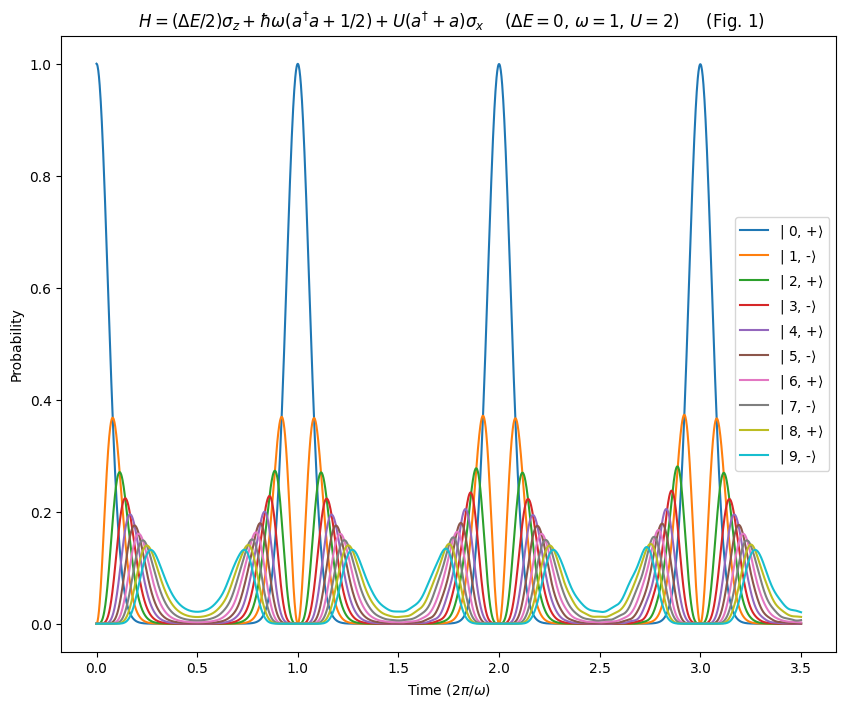

In [12]:
plot_sim(times/(2*np.pi),result.expect,labels=ket_labels)
plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");


In [13]:
result = sesolve(H, psi0, times, e_ops=[number])

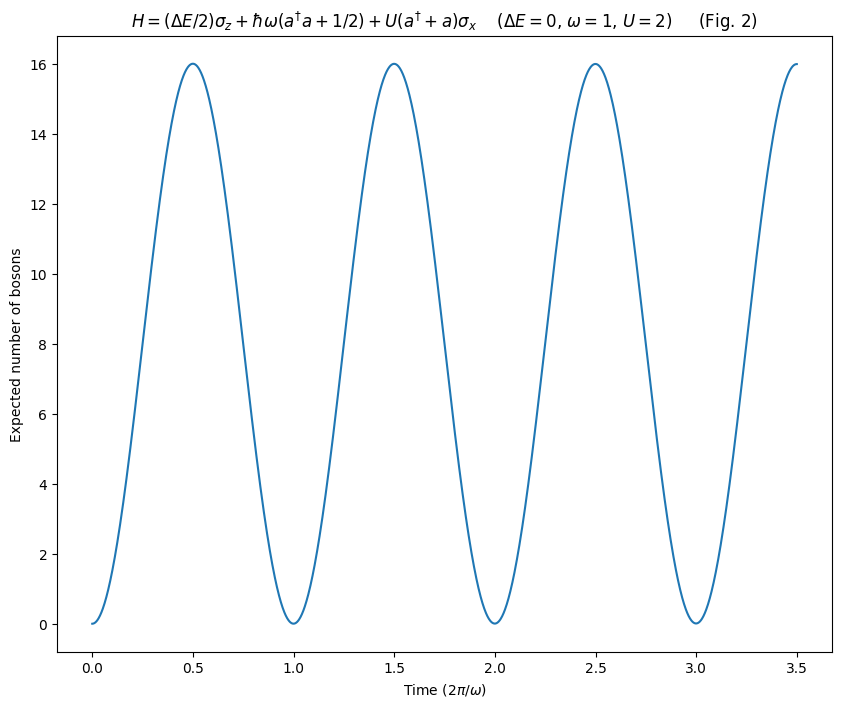

In [14]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[0], label="Expected number of phonons")

plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

Let's see how this looks if we animation the fock distribution over time.

We need the full wave functions for this, so we need to run the simulation again without the expectation operators.

In [15]:
result = sesolve(H, psi0, times)

In [16]:
# Define simulation parameters
num_levels = result.states[0].shape[0]  # Number of Fock states (Hilbert space dimension)
# Create figure
fig, ax = plt.subplots(figsize=(6, 5))  # 3D plot

# Initial plot
plot_fock_distribution(result.states[0], ax=ax)  # Plot first frame
ax.set_title(f"Fock Distribution at t/(2π) = {times[0] / (2 * np.pi):.2f}")

# Function to update each frame
def update(frame):
    ax.clear()  # Clear the previous plot
    plot_fock_distribution(result.states[frame], ax=ax)  # Redraw the Fock distribution

    # Update title with time
    ax.set_title(f"Fock Distribution at t/(2π) = {times[frame] / (2 * np.pi):.2f}")
    ax.set_xlabel("Boson number state")
    ax.set_ylabel("Probability")

    return ax

# Set up animation
frame_indices = np.arange(0, len(times), 10)  # Use every frame
ani = animation.FuncAnimation(fig, update, frames=frame_indices, interval=50, blit=False)

# Suppress static plot
plt.close(fig)

In [17]:
%%time
# Save the animation as a file
ani.save('ani_fock.mp4', writer='ffmpeg', fps=30)

CPU times: user 7.8 s, sys: 744 ms, total: 8.55 s
Wall time: 7.56 s


In [18]:
Video("ani_fock.mp4") 

### Non-degenerate case $\Delta E \neq 0$

In [19]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 0.5
omega = 1
U = 2

In [20]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [21]:
times = np.linspace(0.0, 5.5*2*np.pi, 2000)

In [22]:
projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]
result = sesolve(H, psi0, times, e_ops=projection_operators)

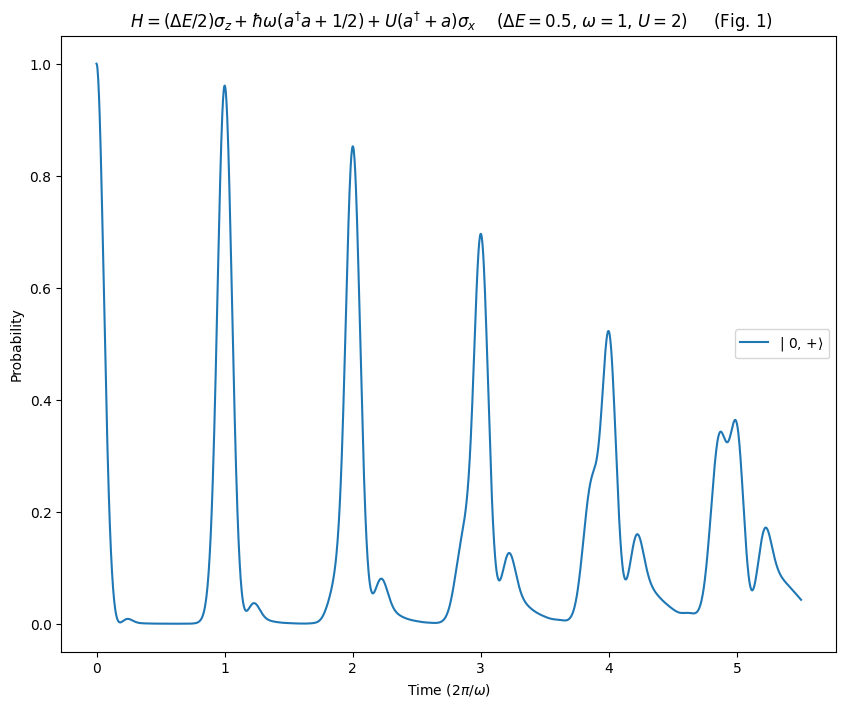

In [23]:
plot_sim(times/(2*np.pi),result.expect[:1],labels=ket_labels)
plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");


There appears to be a small discrepancy with the result in the Casanova paper. This discrepancy does not vanish if we increase the `max_bosons`.


Let's take a look at the boson statistics.

In [24]:
photon_probs = np.array(result.expect)

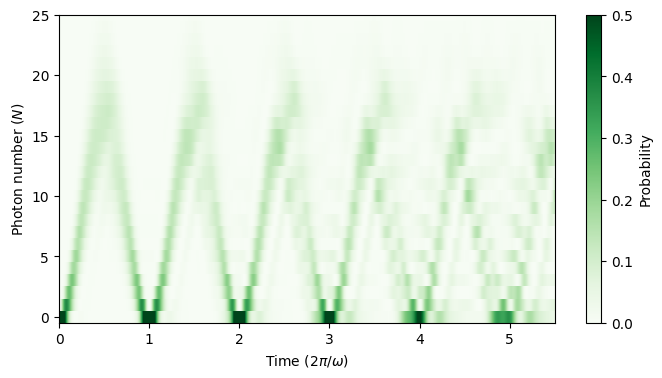

In [25]:
# Plot
plt.figure(figsize=(8, 4))
plt.pcolormesh(times/(2*np.pi), np.arange(max_bosons+1), photon_probs, shading='auto', cmap='Greens', vmax=0.5)
plt.colorbar(label="Probability")
plt.xlabel("Time ($2\pi/\omega$)")
plt.ylabel("Photon number ($N$)")
plt.ylim(top=25)

plt.show()

Looks the same as the paper.

Let's once again look at the fock distribution

In [26]:
result = sesolve(H, psi0, times)

In [27]:
# Define simulation parameters
num_levels = result.states[0].shape[0]  # Number of Fock states (Hilbert space dimension)
# Create figure
fig, ax = plt.subplots(figsize=(6, 5))  # 3D plot

# Initial plot
plot_fock_distribution(result.states[0], ax=ax)  # Plot first frame
ax.set_title(f"Fock Distribution at t/(2π) = {times[0] / (2 * np.pi):.2f}")

# Function to update each frame
def update(frame):
    ax.clear()  # Clear the previous plot
    plot_fock_distribution(result.states[frame], ax=ax)  # Redraw the Fock distribution

    # Update title with time
    ax.set_title(f"Fock Distribution at t/(2π) = {times[frame] / (2 * np.pi):.2f}")
    ax.set_xlabel("Boson number state")
    ax.set_ylabel("Probability")

    return ax

# Set up animation
frame_indices = np.arange(0, len(times), 10)  # Use every frame
ani = animation.FuncAnimation(fig, update, frames=frame_indices, interval=50, blit=False)

# Suppress static plot
plt.close(fig)

In [28]:
%%time
# Save the animation as a file
ani.save('ani_fock_2.mp4', writer='ffmpeg', fps=30)

CPU times: user 7.29 s, sys: 1.14 s, total: 8.43 s
Wall time: 6.94 s


In [29]:
Video("ani_fock_2.mp4") 

We can see that the wave-packet like formation quickly disperses.

Now let's check out the Wigner plots.

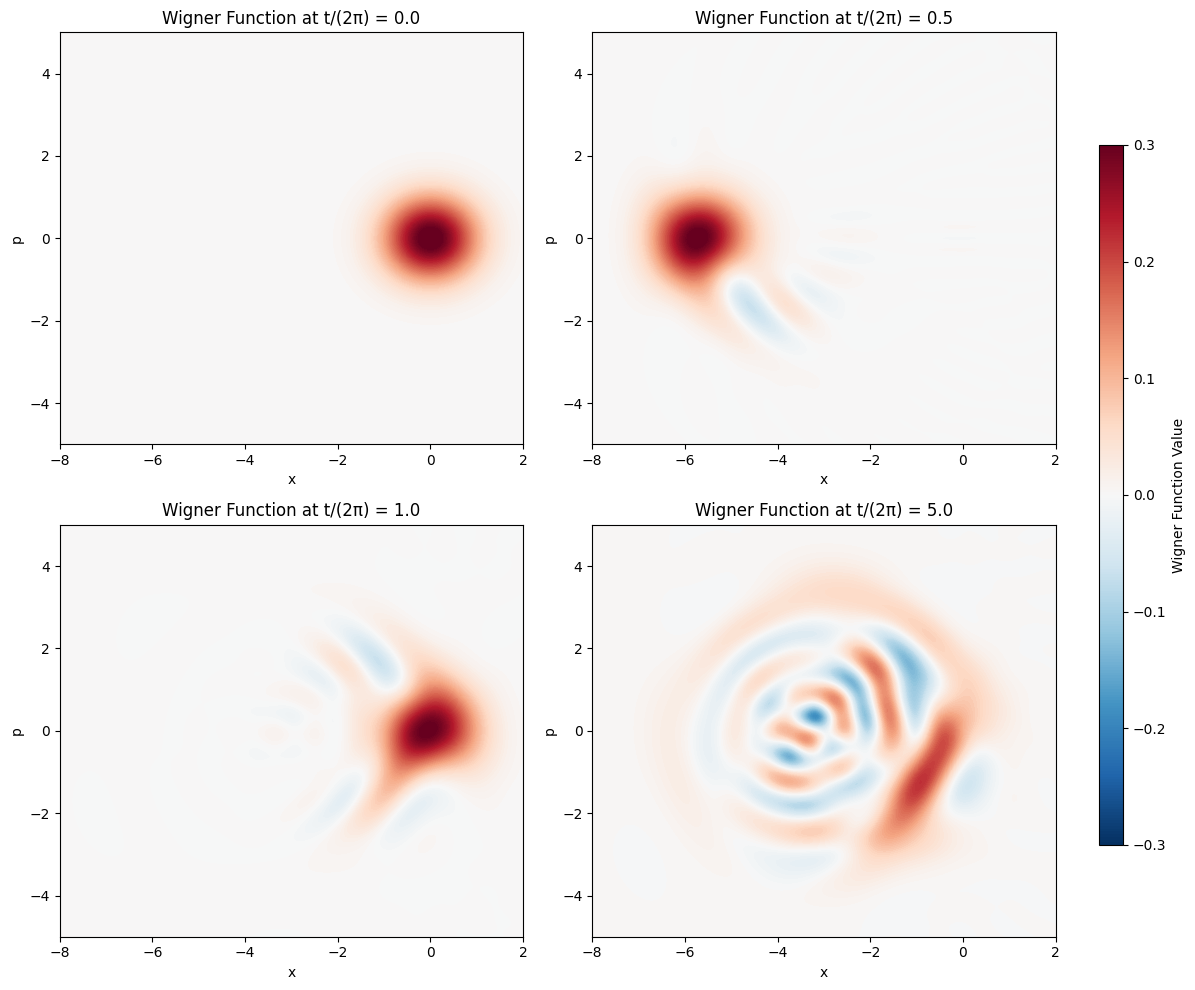

In [30]:
# Define time points we want to plot
t_values = [0, 0.5, 1, 5]  # Corresponding t/(2π) values
t_indices = [np.argmin(np.abs(times - (t * 2 * np.pi))) for t in t_values]  # Find closest indices

# Define phase-space grid
xvec = np.linspace(-8, 2, 200)  # High resolution for smooth contours
pvec = np.linspace(-5, 5, 200)
X, P = np.meshgrid(xvec, pvec)  # Create 2D grid

# Manually specify the color scale
vmin, vmax = -0.3, 0.3  # Adjust as needed

# Create 2×2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Loop through time values and plot in grid
for idx, ax in enumerate(axes.flat):
    state_at_time = result.states[t_indices[idx]]  # Get pure state (ket)
    W = wigner(state_at_time, xvec, pvec)  # Compute Wigner function directly

    # Use contourf for smooth shading
    cont = ax.contourf(X, P, W, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)

    # Set axis labels and title
    ax.set_xlabel("x")
    ax.set_ylabel("p")
    ax.set_title(f"Wigner Function at t/(2π) = {t_values[idx]:.1f}")

# Add a single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for colorbar
sm = cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label="Wigner Function Value")  # Use ScalarMappable for proper scaling

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for colorbar
plt.show()


Qualitative similarities, but there is some difference in the axis values.

Let's animate this to get a better sense of the evolution.

Let's run the simulation for longer this time - instead of $t/(2\pi/\omega)=5$ let's go for 20.

In [31]:
times = np.linspace(0.0, 20*2*np.pi, 2000)
result = sesolve(H, psi0, times)

IndexError: list index out of range

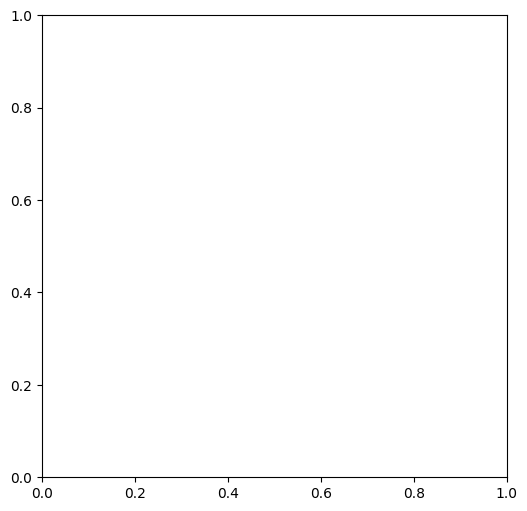

In [428]:
# http://old.rqc.ru/quantech/wiggalery.php wigner examples

# Define phase-space grid
xvec = np.linspace(-8, 8, 100)
pvec = np.linspace(-8, 8, 100)
X, P = np.meshgrid(xvec, pvec)  # Create grid for plotting

# Manually set the color scale (same for all frames)
vmin, vmax = -0.3, 0.3  # Adjust as needed

# Create figure and initial plot
fig, ax = plt.subplots(figsize=(6, 6))
W = wigner(result.states[0], xvec, pvec)  # Compute initial Wigner function

# Use contourf for smooth shading
cont = ax.contourf(X, P, W, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)

# Ensure aspect ratio is square
ax.set_aspect('equal')

# Get position of the main plot
pos = ax.get_position()  # Returns [x0, y0, width, height]

# Create a colorbar axis that matches the height of the main plot
cbar_ax = fig.add_axes([pos.x1 + 0.02, pos.y0, 0.03, pos.height])  # Align with ax

# Create ScalarMappable for proper colorbar scaling
sm = cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=vmin, vmax=vmax))

# Add colorbar
cbar = plt.colorbar(sm, cax=cbar_ax, label="Wigner Function Value")

def update(frame):
    W = wigner(result.states[frame], xvec, pvec)  # Compute new Wigner function
    
    # Remove previous contours before drawing new ones
    for coll in ax.collections:
        coll.remove()
    
    # Redraw contour plot
    cont = ax.contourf(X, P, W, levels=100, cmap="RdBu_r", vmin=vmin, vmax=vmax)
    
    # Update title
    ax.set_title(f"Wigner Function at t/(2π) = {times[frame] / (2 * np.pi/omega):.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("p")

    return cont  # Correct return value


# Set up animation (use every frame for comparison)
frame_indices = np.arange(0, len(times), 5)  # Use every frame

ani = animation.FuncAnimation(fig, update, frames=frame_indices, interval=50, blit=False)

# Suppress static plot
plt.close(fig)


%%time
# Save the animation as a file
ani.save('ani_wigner.mp4', writer='ffmpeg', fps=30)

Video("ani_wigner.mp4") 

In [33]:
%%time
# Save the animation as a file
ani.save('ani_wigner.mp4', writer='ffmpeg', fps=30)

CPU times: user 27.2 s, sys: 3.12 s, total: 30.3 s
Wall time: 28.9 s


In [ ]:
from IPython.display import Video
Video("ani_wigner.mp4") 

## Phase transition

According to a [2015 PRL by Hwang et al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.180404), as $\Delta E/ \hbar\omega \rightarrow \infty$ a phase transition will happen:

$$V \equiv \frac{2U}{\sqrt{\Delta E \hbar \omega} } > 1$$

or in terms of $g \equiv U/\hbar\omega$:

$$V \equiv 2g \sqrt{\frac{\hbar\omega}{\Delta E}}> 1$$

This phase transition involves a change in the number of bosons from zero to:

$$\frac{\hbar\omega}{\Delta E} \langle N \rangle = \frac{V^4 - 1}{4V^2}$$

In the limit of large $V$:

$$ \langle N \rangle \rightarrow g^2$$

In [33]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 20
omega = 1

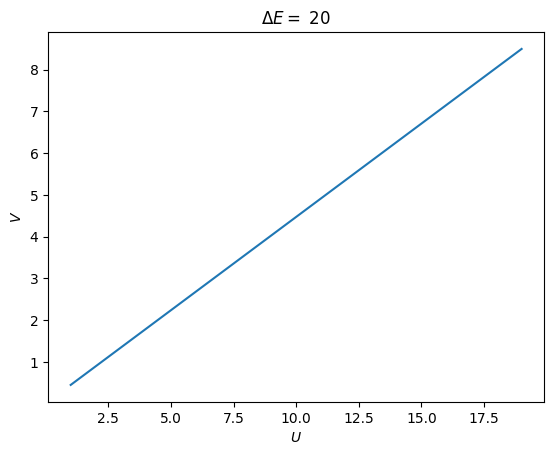

In [10]:
Us = np.arange(1,20)
Vs = 2*Us/np.sqrt(DeltaE*omega)

plt.plot(Us,Vs)
plt.xlabel('$U$');
plt.ylabel('$V$');
plt.title(f'$\Delta E =$ {DeltaE}');

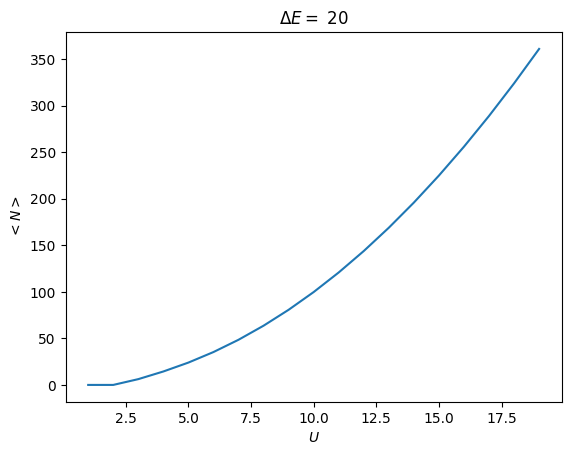

In [11]:


# Set Ns to zero when Vs < 1
Ns = np.where(Vs >= 1, DeltaE / omega * (Vs**4 - 1) / (4 * Vs**2), 0)

plt.plot(Us,Ns)
plt.xlabel('$U$');
plt.ylabel('$<N>$');
plt.title(f'$\Delta E =$ {DeltaE}');

Let's use two values $U=2$ for below transition and $U=10$ for above. 

The reason we choose 10 is we want to be a good chunk above the threshold because things are probably complicated close to it.

We're going to need to up the `max_bosons` for this.

After trying a few simulations, `max_bosons=500` is the minimum for the $U=10$ simulation to converge

In [25]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=700, parity=-1)
bra_labels, ket_labels = make_braket_labels(nm_list)

In [26]:
nm_list[0]

(0, '-')

In [27]:
psi0 = basis(len(nm_list), 0)

In [28]:
U=2

In [34]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [35]:
times = np.linspace(0.0, 5.5*2*np.pi, 2000)

In [36]:
projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]
result = sesolve(H, psi0, times, e_ops=projection_operators[:10])

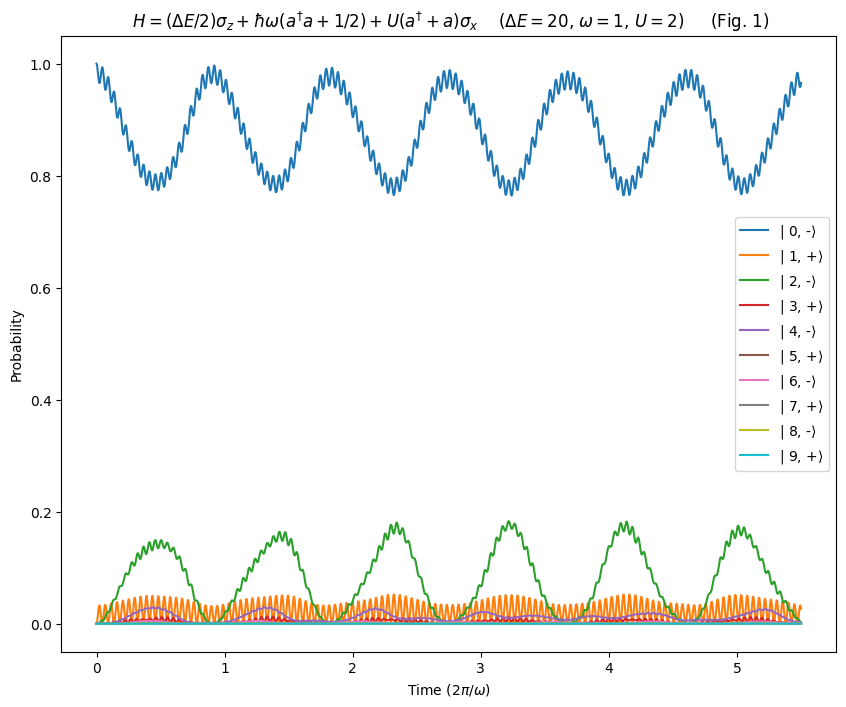

In [37]:
plot_sim(times/(2*np.pi),result.expect,labels=ket_labels)
plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");


In [40]:
result = sesolve(H, psi0, times, e_ops=[number, two_state+0.5])

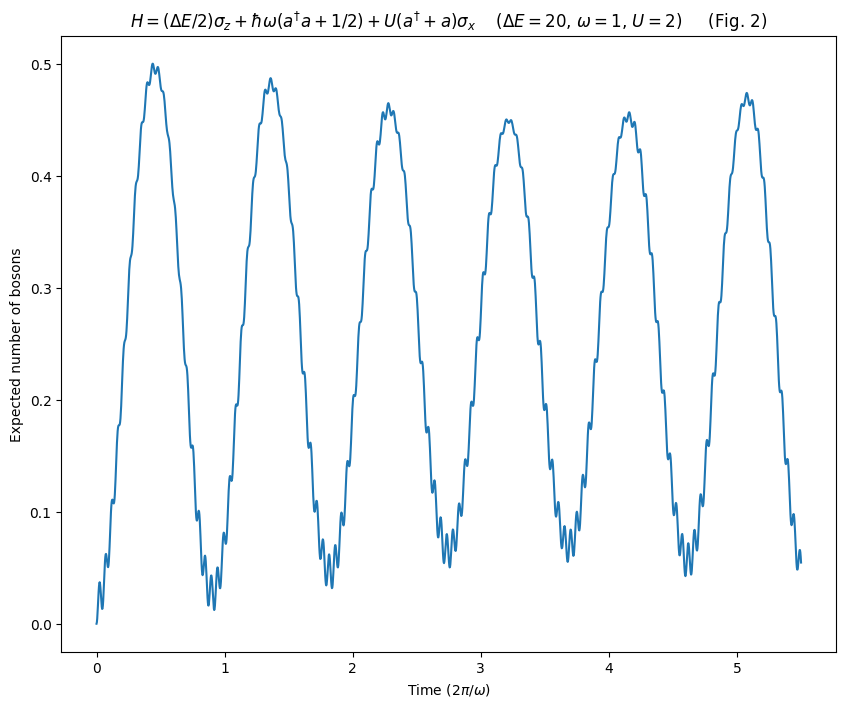

In [41]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[0], label="Expected number of phonons")

plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

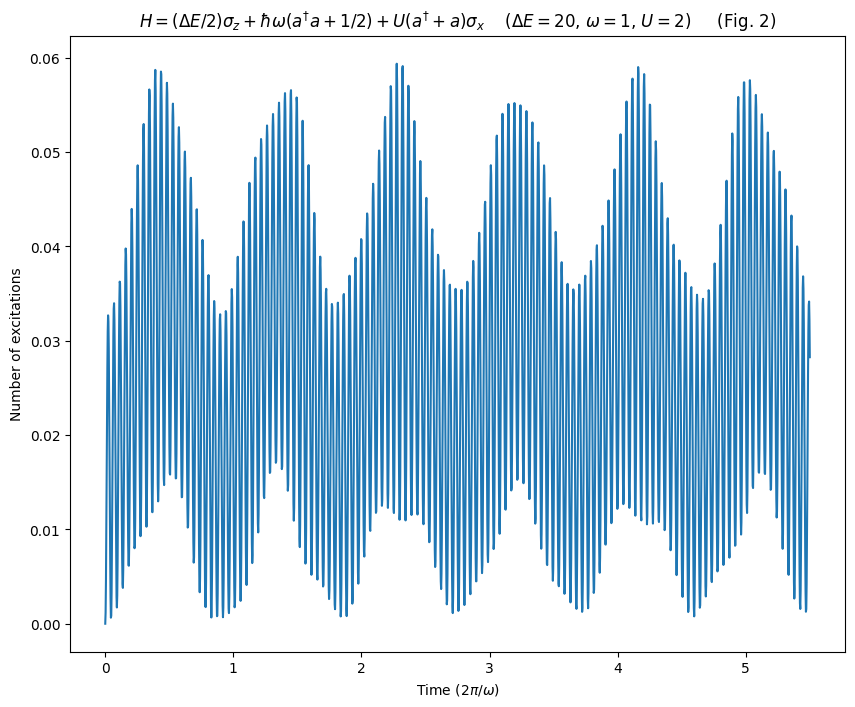

In [42]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[1], label="Number of excitations")

plt.ylabel("Number of excitations")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

In [43]:
# plot_sim(times/(2*np.pi),result.expect,labels=ket_labels)
# plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 1)");
# plt.xlabel("Time ($2\pi/\omega$)");


In [44]:
U=10

In [45]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [46]:
times = np.linspace(0.0, 20.5*2*np.pi, 2000)

In [47]:
psi0 = basis(len(nm_list), 0)

In [48]:
result = sesolve(H, psi0, times, e_ops=[number, two_state+0.5])

In [49]:
# projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]
# result = sesolve(H, psi0, times, e_ops=projection_operators[:10])

In [50]:
# plot_sim(times/(2*np.pi),result.expect,labels=ket_labels)
# plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 1)");
# plt.xlabel("Time ($2\pi/\omega$)");


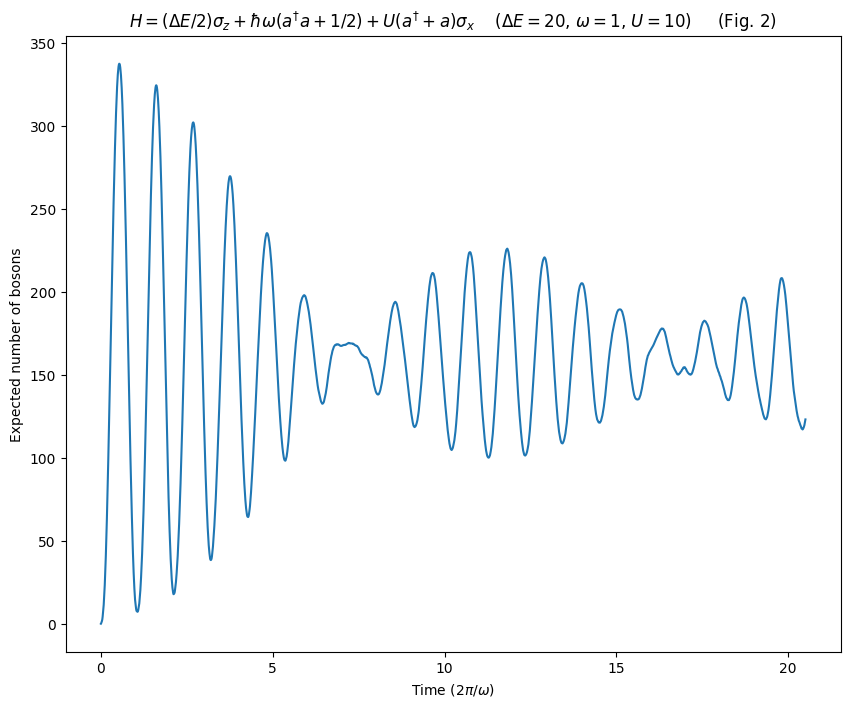

In [51]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[0], label="Expected number of phonons")

plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

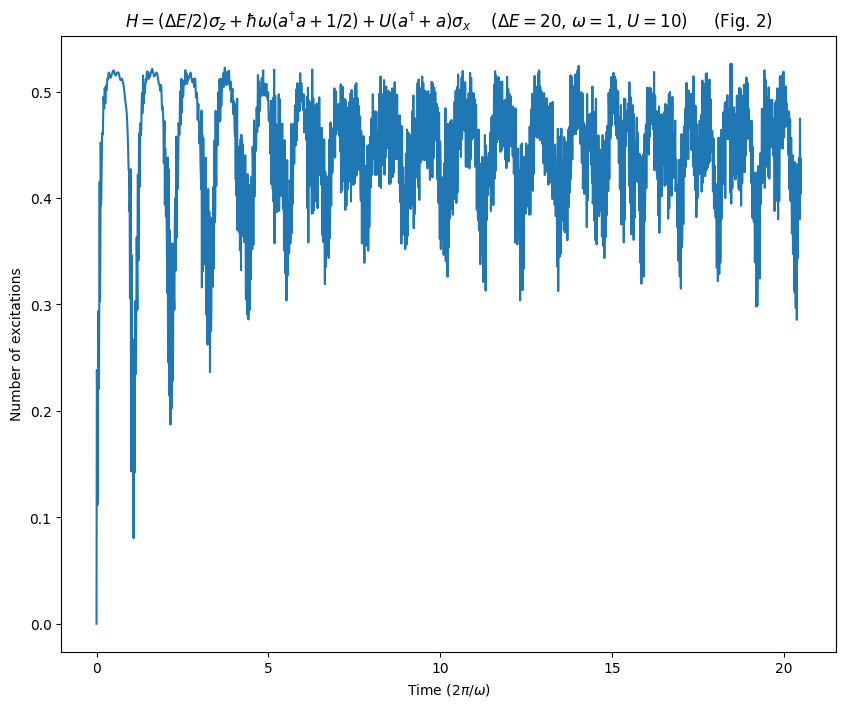

In [52]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[1], label="Number of excitations")

plt.ylabel("Number of excitations")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

Now let's try setting up the system with 40 bosons and with the TLS in the ground state.

In [53]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=700, parity=-1)
bra_labels, ket_labels = make_braket_labels(nm_list)

In [54]:
nm_list[40]

(40, '-')

In [55]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [56]:
times = np.linspace(0.0, 20.5*2*np.pi, 2000)

In [57]:
psi0 = basis(len(nm_list), 39)

In [58]:
result = sesolve(H, psi0, times, e_ops=[number, two_state+0.5])

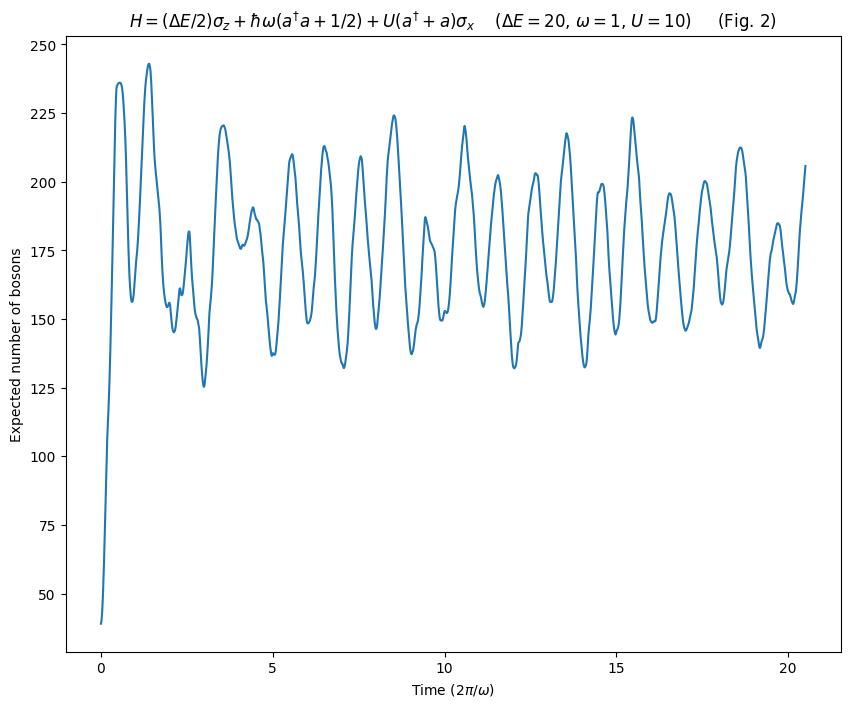

In [59]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[0], label="Expected number of phonons")

plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

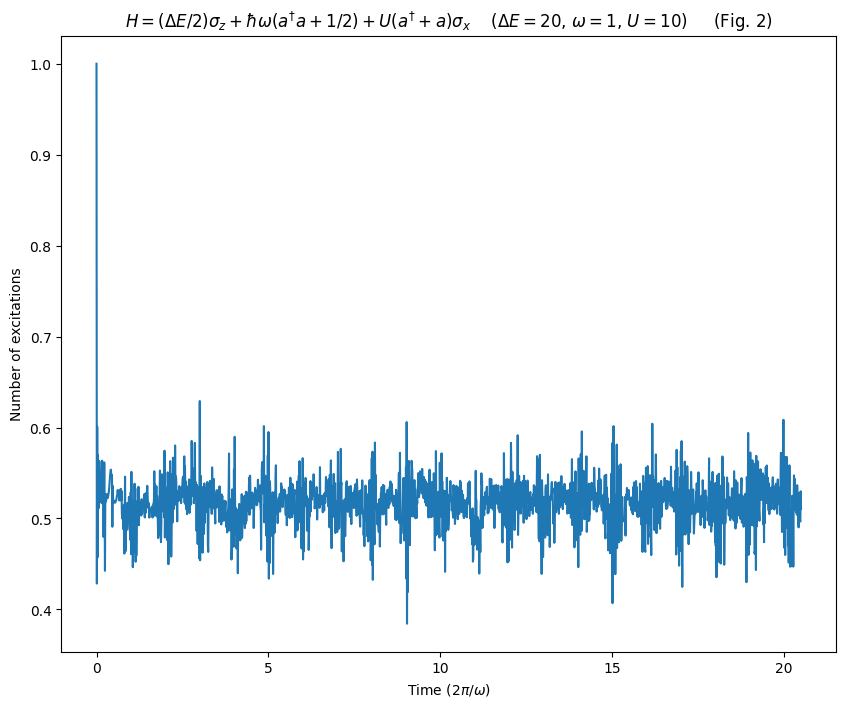

In [60]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[1], label="Number of excitations")

plt.ylabel("Number of excitations")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

## Strong field

In [238]:
max_bosons = 800

In [239]:
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=-1)
bra_labels, ket_labels = make_braket_labels(nm_list)

In [240]:
nm_list[400]

(400, '-')

In [241]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 20
omega = 1
U = 1

In [242]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [243]:
times = np.linspace(0.0, 0.5*2*np.pi, 1000)

In [244]:
psi0 = basis(len(nm_list), 400)

In [245]:
result = sesolve(H, psi0, times, e_ops=[number, two_state+0.5])

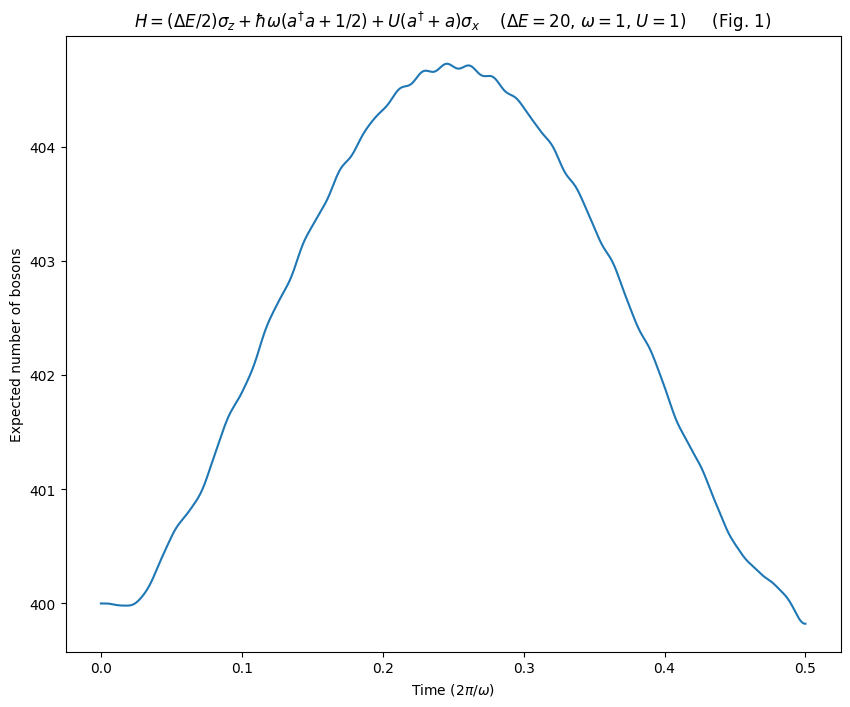

In [246]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[0], label="Expected number of phonons")

plt.ylabel("Expected number of bosons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 1)")
plt.show();

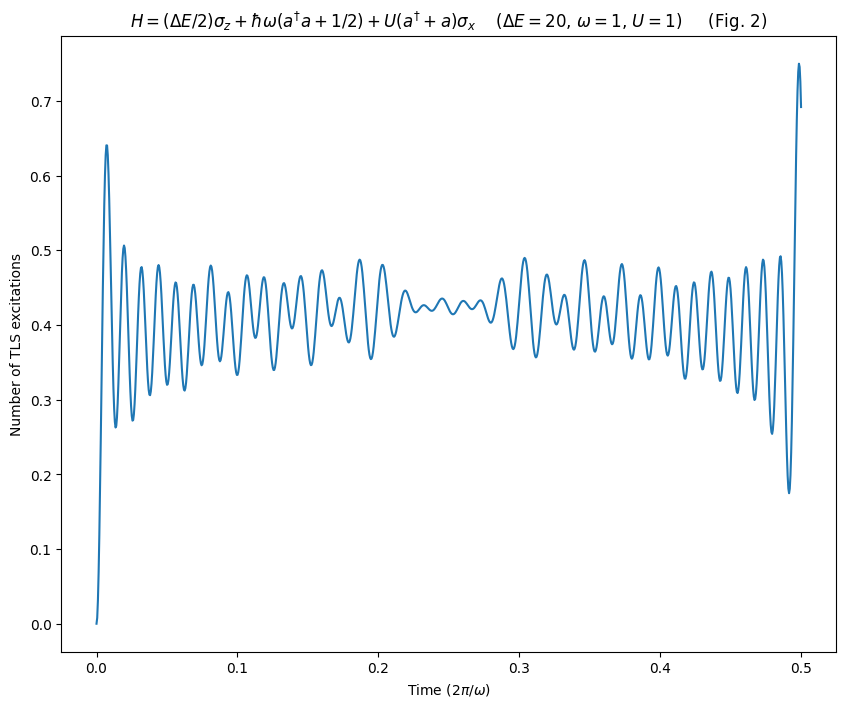

In [247]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[1], label="Number of TLS excitations")

plt.ylabel("Number of TLS excitations")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 2)")
plt.show();

In [255]:
def projectors_all_n(nm_list):
    N = len(nm_list)
    
    # Find all unique boson numbers
    n_values = sorted(set(n for (n, m) in nm_list))
    
    # Group projectors by boson number
    projectors_by_n = []
    for n_target in n_values:
        proj_group = [
            basis(N, i).proj()
            for i, (n, m) in enumerate(nm_list)
            if n == n_target
        ]
        # Combine all TLS states for given n into one projector
        if proj_group:
            P_total = sum(proj_group)
            projectors_by_n.append(P_total)
    
    return projectors_by_n

In [256]:
projection_operators = projectors_all_n(nm_list)
result = sesolve(H, psi0, times, e_ops=projection_operators)

In [257]:
# projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]
# result = sesolve(H, psi0, times, e_ops=projection_operators)

In [258]:
photon_probs = np.array(result.expect)

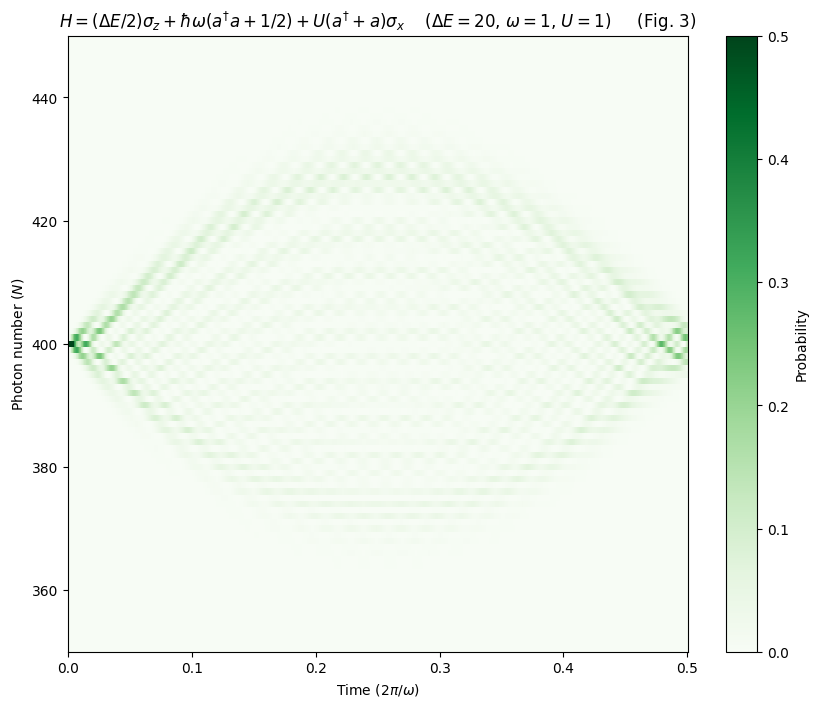

In [259]:
# Plot
plt.figure(figsize=(10,8))
plt.pcolormesh(times/(2*np.pi), np.arange(max_bosons+1), photon_probs, shading='auto', cmap='Greens', vmax=0.5)
plt.colorbar(label="Probability")
plt.xlabel("Time ($2\pi/\omega$)")
plt.ylabel("Photon number ($N$)")
plt.ylim(bottom=350,top=450)
plt.title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig. 3)")

plt.show()

In [278]:
result = sesolve(H, psi0, times)

In [279]:
# Define simulation parameters
num_levels = result.states[0].shape[0]  # Number of Fock states (Hilbert space dimension)
# Create figure
fig, ax = plt.subplots(figsize=(6, 5))  # 3D plot

# Initial plot
plot_fock_distribution(result.states[0], ax=ax)  # Plot first frame
ax.set_title(f"Fock Distribution at t/(2π) = {times[0] / (2 * np.pi):.2f}")

# Function to update each frame
def update(frame):
    ax.clear()  # Clear the previous plot
    plot_fock_distribution(result.states[frame], ax=ax)  # Redraw the Fock distribution

    # Update title with time
    # ax.set_title(f"Fock Distribution at t/(2π) = {times[frame] / (2 * np.pi):.2f}")
    ax.set_title(f"{H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$) \n Fock Distribution at t/(2π) = {times[frame] / (2 * np.pi):.2f}")
    ax.set_xlabel("Boson number state")
    ax.set_ylabel("Probability")
    ax.set_xlim(300,500)

    return ax

# Set up animation
frame_indices = np.arange(0, len(times), 1)  #
ani = animation.FuncAnimation(fig, update, frames=frame_indices, interval=50, blit=False)

# Suppress static plot
plt.close(fig)

In [280]:
%%time
# Save the animation as a file
ani.save('ani_fock_strong_field_short_time.mp4', writer='ffmpeg', fps=30)

CPU times: user 4min 53s, sys: 3.34 s, total: 4min 57s
Wall time: 4min 58s


In [1]:
Video("ani_fock_strong_field_short_time.mp4") 

NameError: name 'Video' is not defined

## Realistic nuclear parameters

In [74]:
max_bosons =1000
two_state, bosons, interaction, number, nm_list = make_operators(max_bosons=max_bosons, parity=1)

In [91]:
# These are realistic parameters for Pd nuclear transition and coupling with phonons 
# U/DeltaE = 0.01

DeltaE = 10**14
omega =1
U = 1000

times = np.linspace(0.0, 50e-10, 2000)

In [92]:
H =  DeltaE*two_state + omega*bosons + U*interaction

In [93]:
psi0 = basis(len(nm_list), 0)


In [94]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [95]:
projection_operators = [basis(len(nm_list), i) * basis(len(nm_list), i).dag() for i in range(len(nm_list))]
result = sesolve(H, psi0, times, e_ops=projection_operators[:10])

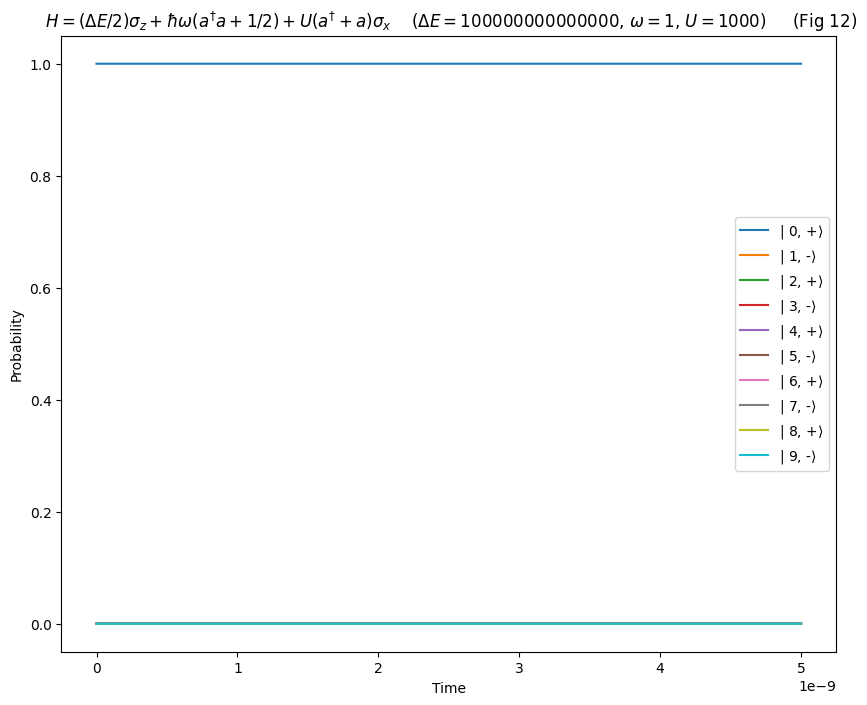

In [80]:
plot_sim(times,result.expect,labels=ket_labels)
plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)");


In [917]:
result = sesolve(H, psi0, times, e_ops=[H, DeltaE*two_state, omega*bosons, U*interaction, number ])

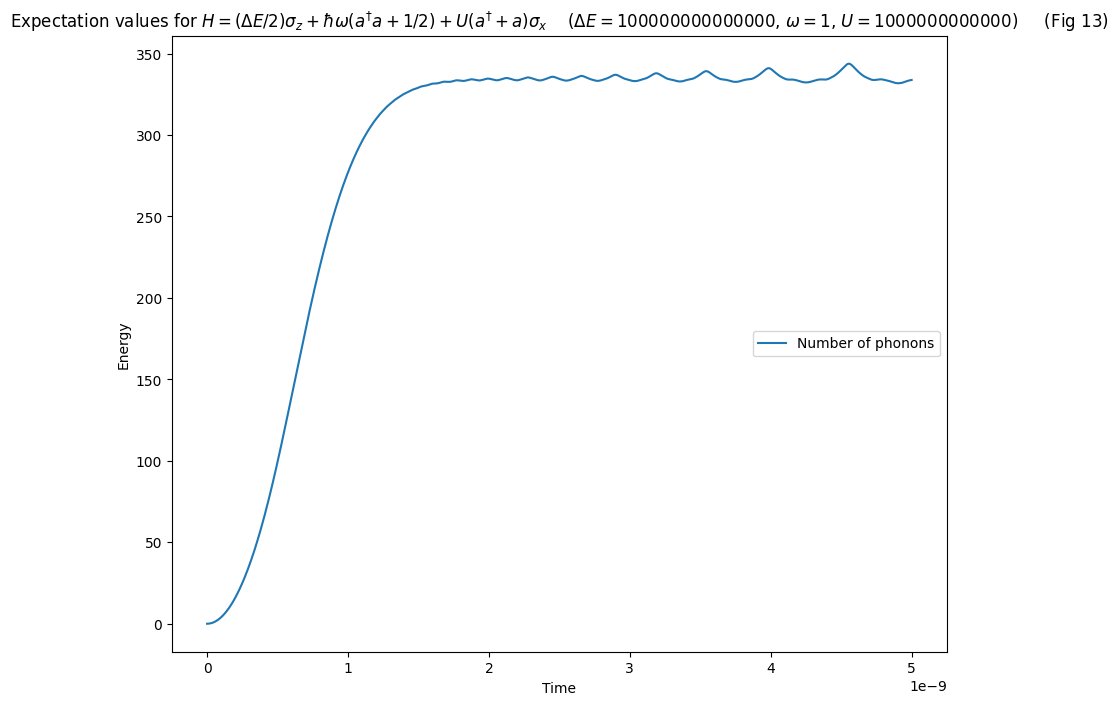

In [918]:
plt.figure(figsize=(10,8))
# plt.plot(times, result.expect[0], label="$H$ - Total Hamiltonian")
# plt.plot(times, result.expect[1], label="$(\Delta E/2) \sigma_z$ - TSS")
# plt.plot(times, result.expect[2], label="$\hbar\omega(a^{{\dagger}}a +1/2)$ - bosons")
# plt.plot(times, result.expect[3], label="$U( a^{{\dagger}} + a )\sigma_x$ - interaction")
plt.plot(times, result.expect[4], label="Number of phonons")

plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig 13)")
plt.show();

# 2 oscillators

In [884]:
H_latex_2 = "$H = (\Delta E / 2) \sigma_z + \hbar\omega_1(a_1^{{\dagger}}a_1) + \hbar\omega_2(a_2^{{\dagger}}a_2) + U_1( a_1^{{\dagger}} + a_1 )\sigma_x + U_2( a_2^{{\dagger}} + a_2 )\sigma_x$"

In [708]:
def make_operators_3(max_bosons_1, max_bosons_2, parity=0):
    a1     = tensor(destroy(max_bosons_1+1), qeye(max_bosons_2+1), qeye(2))     # tensorised boson destruction operator
    a2   = tensor(qeye(max_bosons_1+1), destroy(max_bosons_2+1), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx   = tensor(qeye(max_bosons_1+1), qeye(max_bosons_2+1), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz   = tensor(qeye(max_bosons_1+1), qeye(max_bosons_2+1), sigmaz())       # tensorised 𝜎z1 operator 

    
    two_state     =  1/2*sz                                  # two state system energy operator   𝜎𝑧1/2
    bosons_1          = (a1.dag()*a1)                           # boson energy operator              𝑎†𝑎+1/2
    bosons_2          = (a2.dag()*a2)
    number_1          = a1.dag()*a1                                 # boson number operator              𝑎†𝑎
    number_2          = a2.dag()*a2
    interaction_1   = (a1.dag() + a1) * sx                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a2.dag() + a2) * sx                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz*(1j*np.pi*(number_1+number_2)).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns1 = range(0, max_bosons_1+1)
    possible_ns2 = range(0, max_bosons_2+1)
    possible_ms = ["+","-"]
    nnm_list = [(n1,n2,m) for (n1,n2,m) in product(possible_ns1, possible_ns2, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    
        two_state       = two_state.extract_states(p)
        bosons_1         = bosons_1.extract_states(p)
        number_1         = number_1.extract_states(p)
        bosons_2         = bosons_2.extract_states(p)
        number_2         = number_2.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        P               = P.extract_states(p)
        nnm_list        = [nnm_list[i] for i in p]

    return two_state, bosons_1, bosons_2, interaction_1, interaction_2, number_1, number_2, nnm_list

In [709]:
# assuming nnm_list has the new mapping (n1, n2, ±) in reduced space

def projectors_n1_in_reduced_basis(nnm_list, n1_target):
    N = len(nnm_list)
    from qutip import basis
    return [
        basis(N, i).proj()
        for i, (n1, _, _) in enumerate(nnm_list)
        if n1 == n1_target
    ]


In [710]:

def projectors_all_n1(nnm_list):
    N = len(nnm_list)
    
    # Find all unique n1 values in the reduced basis
    n1_values = sorted(set(n1 for (n1, _, _) in nnm_list))
    
    # Build a list of lists of projectors grouped by n1 value
    projectors_by_n1 = []
    for n1_target in n1_values:
        proj_group = [
            basis(N, i).proj()
            for i, (n1, _, _) in enumerate(nnm_list)
            if n1 == n1_target
        ]
        # Combine into a single projection operator for that n1
        if proj_group:
            P_total = sum(proj_group)
            projectors_by_n1.append(P_total)
    
    return projectors_by_n1


In [711]:


def projectors_all_n2(nnm_list):
    N = len(nnm_list)
    
    # Find all unique n1 values in the reduced basis
    n2_values = sorted(set(n2 for (_, n2, _) in nnm_list))
    
    # Build a list of lists of projectors grouped by n2 value
    projectors_by_n2 = []
    for n2_target in n2_values:
        proj_group = [
            basis(N, i).proj()
            for i, (_, n2, _) in enumerate(nnm_list)
            if n2 == n2_target
        ]
        # Combine into a single projection operator for that n2
        if proj_group:
            P_total = sum(proj_group)
            projectors_by_n2.append(P_total)
    
    return projectors_by_n2


In [712]:
max_bosons = 800


In [713]:
two_state, bosons_1, bosons_2, interaction_1, interaction_2, number_1, number_2, nnm_list = make_operators_3(max_bosons_1=max_bosons, max_bosons_2=2, parity=-1)
bra_labels, ket_labels = make_braket_labels(nnm_list)

In [714]:
# Recall that in our units hbar=1 and omega = 1
DeltaE = 20
omega = 1
U1 = 2
U2 = 0.01

In [920]:
H =  DeltaE*two_state + omega*bosons_1 + 114.96*bosons_2 + U1*interaction_1 + U2*interaction_2

In [921]:
energies = H.eigenenergies()

In [922]:
df = make_df_for_energy_scan("$U_1$", 2.0, 2.2, 80, two_state.shape[0])

In [923]:
df.shape

(80, 2404)

In [924]:
# fill the data structure with eigenvalues of the Hamiltonian i.e. the energy levels
for i, row in df.iterrows():
    print(i)
    H =   DeltaE*two_state + omega*bosons_1 + DeltaE*bosons_2 + row["$U_1$"]*interaction_1 + 0.01*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


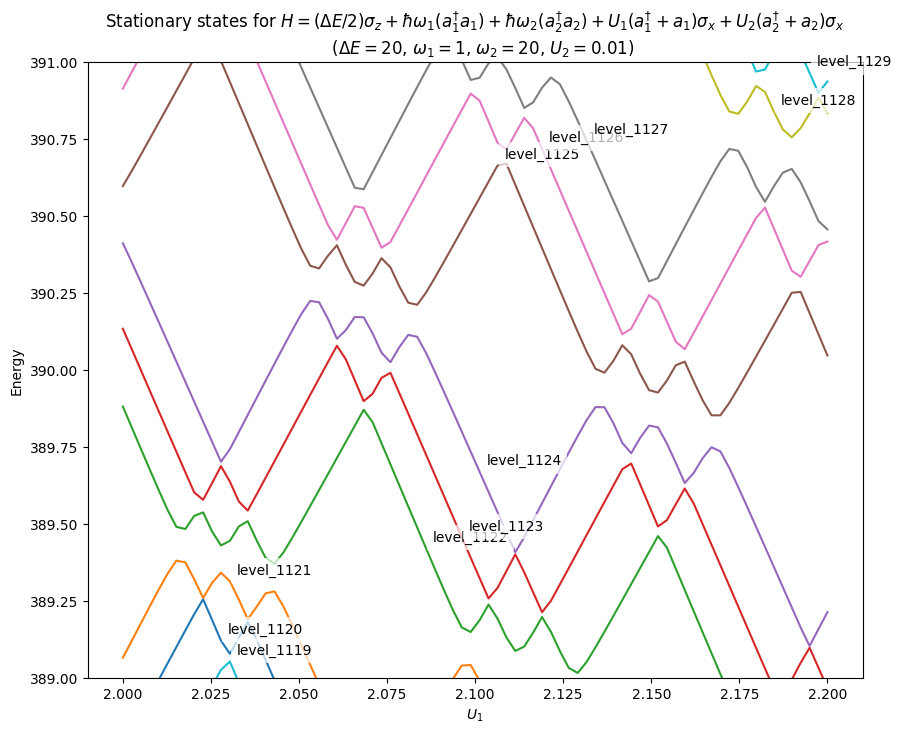

In [926]:
# Your existing plot
fig, ax = plt.subplots(figsize=(10, 8))  # Explicitly create figure and axis
df.plot(x="$U_1$", ax=ax, ylim=[389, 391], legend=False, 
        title=f"Stationary states for {H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_2={U2}$)")
ax.set_ylabel("Energy")

# Assuming df has multiple columns to annotate
# Get the column names (excluding the x-axis column)
columns_to_annotate = [col for col in df.columns if col != "$U_1$"]


# Add annotations for each line
for column in columns_to_annotate:
    x_data = df["$U_1$"]
    y_data = df[column]
    
    # Filter data within the visible y-range
    mask = (y_data >= 389) & (y_data <= 391)
    visible_x = x_data[mask]
    visible_y = y_data[mask]
    
    if not visible_y.empty:
        # Use the middle point of the visible data
        idx = len(visible_y) // 2
        x_pos = visible_x.iloc[idx]
        y_pos = visible_y.iloc[idx]
        
        
        # Add annotation
        ax.annotate(column, 
                    xy=(x_pos, y_pos),          # Point on the line
                    xytext=(5, 5),              # Offset for text
                    textcoords='offset points', 
                    fontsize=10, 
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()

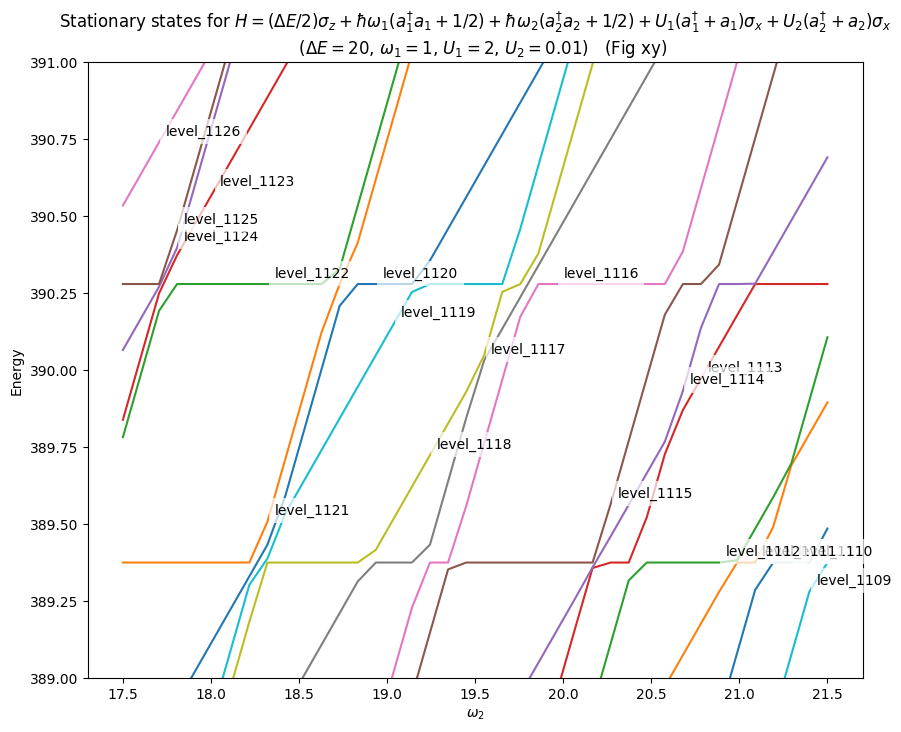

In [762]:
# Your existing plot
fig, ax = plt.subplots(figsize=(10, 8))  # Explicitly create figure and axis
df.plot(x="$\omega_2$", ax=ax, ylim=[389, 391], legend=False, 
        title=f"Stationary states for {H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $U_1={U1}$, $U_2={U2}$)   (Fig xy)")
ax.set_ylabel("Energy")

# Assuming df has multiple columns to annotate
# Get the column names (excluding the x-axis column)
columns_to_annotate = [col for col in df.columns if col != "$\omega_2$"]


# Add annotations for each line
for column in columns_to_annotate:
    x_data = df["$\omega_2$"]
    y_data = df[column]
    
    # Filter data within the visible y-range
    mask = (y_data >= 389) & (y_data <= 391)
    visible_x = x_data[mask]
    visible_y = y_data[mask]
    
    if not visible_y.empty:
        # Use the middle point of the visible data
        idx = len(visible_y) // 2
        x_pos = visible_x.iloc[idx]
        y_pos = visible_y.iloc[idx]
        
        
        # Add annotation
        ax.annotate(column, 
                    xy=(x_pos, y_pos),          # Point on the line
                    xytext=(5, 5),              # Offset for text
                    textcoords='offset points', 
                    fontsize=10, 
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()

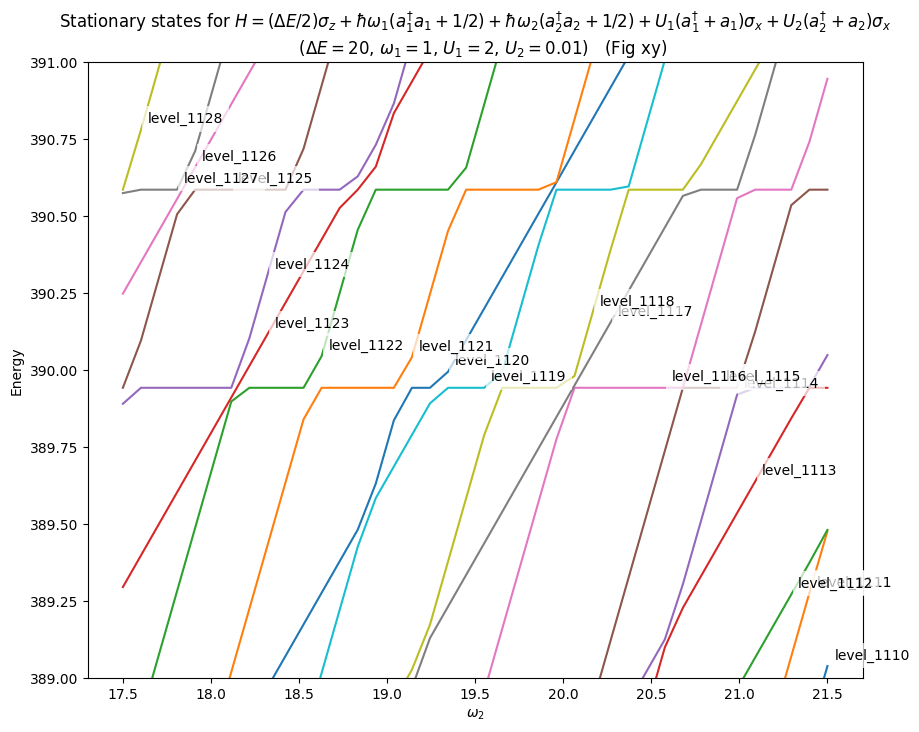

In [760]:
# Your existing plot
fig, ax = plt.subplots(figsize=(10, 8))  # Explicitly create figure and axis
df.plot(x="$\omega_2$", ax=ax, ylim=[389, 391], legend=False, 
        title=f"Stationary states for {H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $U_1={U1}$, $U_2={U2}$)   (Fig xy)")
ax.set_ylabel("Energy")

# Assuming df has multiple columns to annotate
# Get the column names (excluding the x-axis column)
columns_to_annotate = [col for col in df.columns if col != "$\omega_2$"]


# Add annotations for each line
for column in columns_to_annotate:
    x_data = df["$\omega_2$"]
    y_data = df[column]
    
    # Filter data within the visible y-range
    mask = (y_data >= 389) & (y_data <= 391)
    visible_x = x_data[mask]
    visible_y = y_data[mask]
    
    if not visible_y.empty:
        # Use the middle point of the visible data
        idx = len(visible_y) // 2
        x_pos = visible_x.iloc[idx]
        y_pos = visible_y.iloc[idx]
        
        
        # Add annotation
        ax.annotate(column, 
                    xy=(x_pos, y_pos),          # Point on the line
                    xytext=(5, 5),              # Offset for text
                    textcoords='offset points', 
                    fontsize=10, 
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()

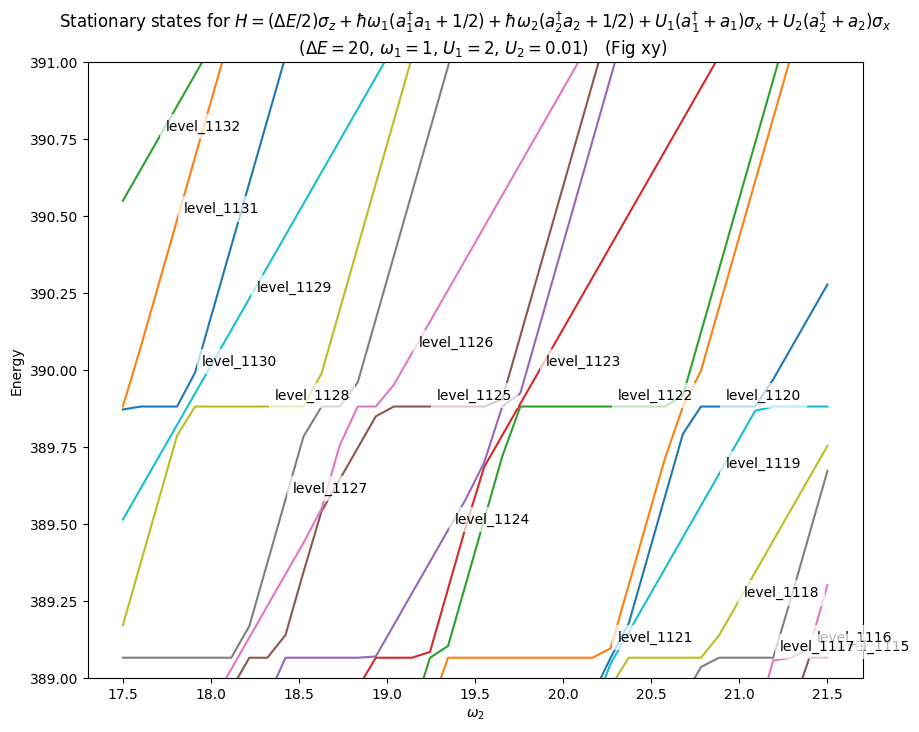

In [758]:
# Your existing plot
fig, ax = plt.subplots(figsize=(10, 8))  # Explicitly create figure and axis
df.plot(x="$\omega_2$", ax=ax, ylim=[389, 391], legend=False, 
        title=f"Stationary states for {H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $U_1={U1}$, $U_2={U2}$)   (Fig xy)")
ax.set_ylabel("Energy")

# Assuming df has multiple columns to annotate
# Get the column names (excluding the x-axis column)
columns_to_annotate = [col for col in df.columns if col != "$\omega_2$"]


# Add annotations for each line
for column in columns_to_annotate:
    x_data = df["$\omega_2$"]
    y_data = df[column]
    
    # Filter data within the visible y-range
    mask = (y_data >= 389) & (y_data <= 391)
    visible_x = x_data[mask]
    visible_y = y_data[mask]
    
    if not visible_y.empty:
        # Use the middle point of the visible data
        idx = len(visible_y) // 2
        x_pos = visible_x.iloc[idx]
        y_pos = visible_y.iloc[idx]
        
        
        # Add annotation
        ax.annotate(column, 
                    xy=(x_pos, y_pos),          # Point on the line
                    xytext=(5, 5),              # Offset for text
                    textcoords='offset points', 
                    fontsize=10, 
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()

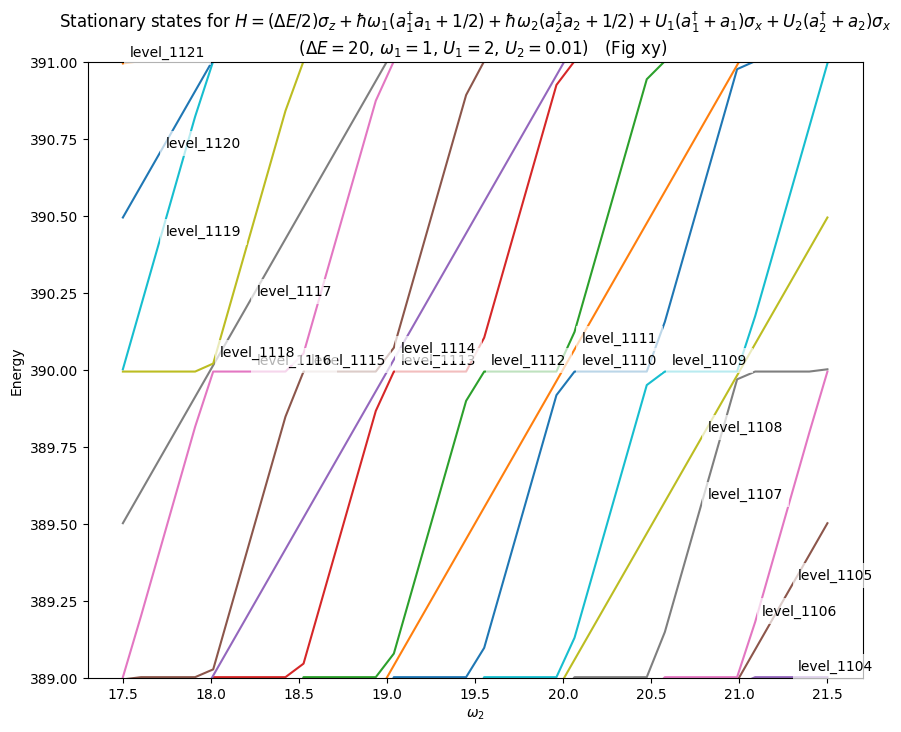

In [756]:
# Your existing plot
fig, ax = plt.subplots(figsize=(10, 8))  # Explicitly create figure and axis
df.plot(x="$\omega_2$", ax=ax, ylim=[389, 391], legend=False, 
        title=f"Stationary states for {H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $U_1={U1}$, $U_2={U2}$)   (Fig xy)")
ax.set_ylabel("Energy")

# Assuming df has multiple columns to annotate
# Get the column names (excluding the x-axis column)
columns_to_annotate = [col for col in df.columns if col != "$\omega_2$"]


# Add annotations for each line
for column in columns_to_annotate:
    x_data = df["$\omega_2$"]
    y_data = df[column]
    
    # Filter data within the visible y-range
    mask = (y_data >= 389) & (y_data <= 391)
    visible_x = x_data[mask]
    visible_y = y_data[mask]
    
    if not visible_y.empty:
        # Use the middle point of the visible data
        idx = len(visible_y) // 2
        x_pos = visible_x.iloc[idx]
        y_pos = visible_y.iloc[idx]
        
        
        # Add annotation
        ax.annotate(column, 
                    xy=(x_pos, y_pos),          # Point on the line
                    xytext=(5, 5),              # Offset for text
                    textcoords='offset points', 
                    fontsize=10, 
                    color='black',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.show()

In [808]:
def level_difference(U1, omega_2, DeltaE, omega_1, U2, level_number):
    H = DeltaE*two_state + omega_1*bosons_1 + omega_2*bosons_2 + U1*interaction_1 + U2*interaction_2
    evals, ekets = H.eigenstates()
    return np.abs(evals[level_number] - evals[level_number-1])

    

In [830]:
anti_crossing = minimize_scalar(level_difference, args=(20, 20, 1, 0.01, 1124), method="Bounded", bounds=[2.075, 2.077])

In [628]:
anti_crossing = minimize_scalar(level_difference, args=(20, 1, 2, 0.01, 1125), method="Bounded", bounds=[19.6, 19.65])

In [831]:
anti_crossing

 message: Solution found.
 success: True
  status: 0
     fun: 5.687853149538569e-05
       x: 2.0752001169339063
     nit: 10
    nfev: 10

In [811]:
# H =  DeltaE*two_state + omega*bosons_1 + 20*bosons_2 + 2.0612478553195*interaction_1 + U2*interaction_2

In [854]:
H =  DeltaE*two_state + omega*bosons_1 + 20*bosons_2 + 2.0752001169339063*interaction_1 + U2*interaction_2

In [833]:
evals, ekets = H.eigenstates()

In [834]:
psi0 = basis(len(nnm_list), 1200)

In [835]:
psi0_in_H_basis = psi0.transform(ekets)

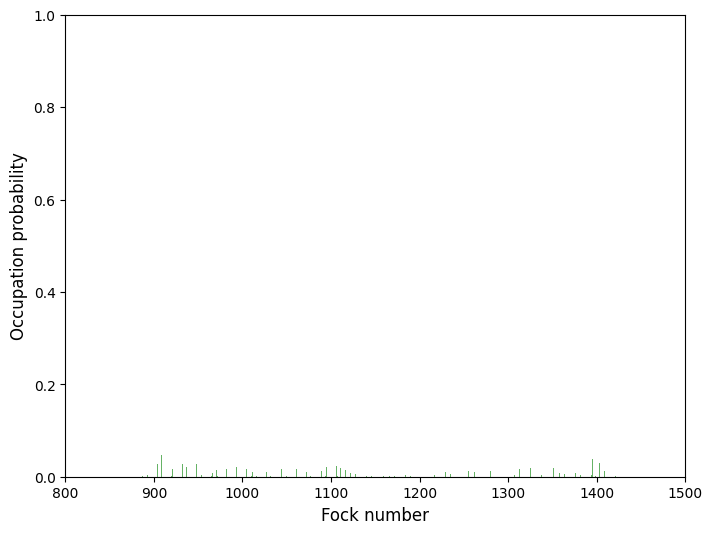

In [836]:
plot_fock_distribution(psi0_in_H_basis)
plt.xlim((800,1500));

In [722]:
expect(two_state,ekets[1125])

0.13186615617682892

In [855]:
expect(H,psi0)

390.0

In [740]:
expect(bosons_2,psi0)

0.0

In [727]:
expect(DeltaE*bosons_2,psi0)

0.0

In [729]:
expect(DeltaE*two_state,psi0)

-10.0

In [674]:
expect(number_1,ekets[1125])

310.65999067508113

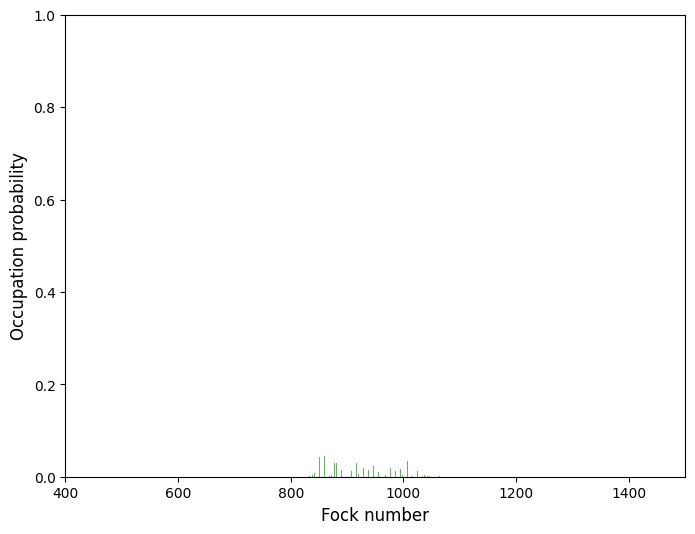

In [803]:
plot_fock_distribution(ekets[1128])
plt.xlim((400,1500));

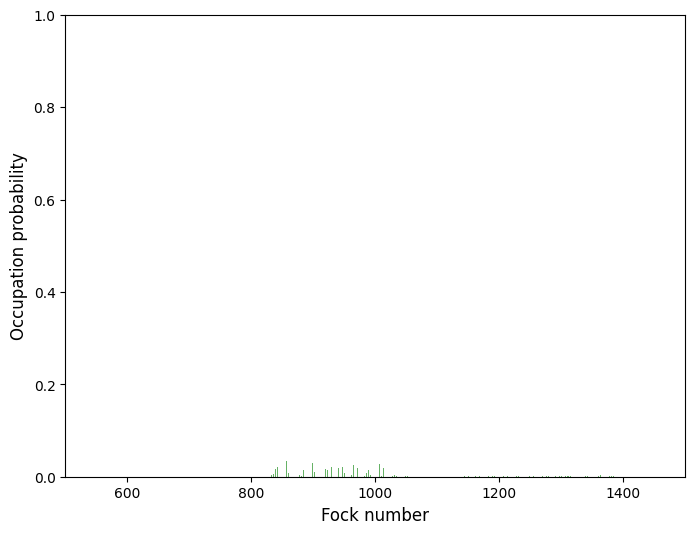

In [859]:
plot_fock_distribution(ekets[1124])
plt.xlim((500,1500));

In [614]:
ekets[14][:20]

array([[-5.51396455e-04+0.j],
       [-9.27833009e-02+0.j],
       [ 1.02781741e-04+0.j],
       [-5.02076567e-03+0.j],
       [ 9.15232623e-01+0.j],
       [-3.38361154e-04+0.j],
       [-8.82293768e-04+0.j],
       [-1.70054100e-01+0.j],
       [ 1.78236384e-04+0.j],
       [ 3.28607272e-05+0.j],
       [ 3.19370558e-01+0.j],
       [-1.28020166e-04+0.j],
       [-5.98556708e-05+0.j],
       [-7.05669100e-02+0.j],
       [ 7.19262890e-05+0.j],
       [-8.43237265e-05+0.j],
       [ 8.87615012e-02+0.j],
       [-3.78937738e-05+0.j],
       [-3.86524413e-05+0.j],
       [-2.12511629e-02+0.j]])

In [616]:
nnm_list[:20]

[(0, 0, '-'),
 (0, 1, '+'),
 (0, 2, '-'),
 (1, 0, '+'),
 (1, 1, '-'),
 (1, 2, '+'),
 (2, 0, '-'),
 (2, 1, '+'),
 (2, 2, '-'),
 (3, 0, '+'),
 (3, 1, '-'),
 (3, 2, '+'),
 (4, 0, '-'),
 (4, 1, '+'),
 (4, 2, '-'),
 (5, 0, '+'),
 (5, 1, '-'),
 (5, 2, '+'),
 (6, 0, '-'),
 (6, 1, '+')]

(0.0, 100.0)

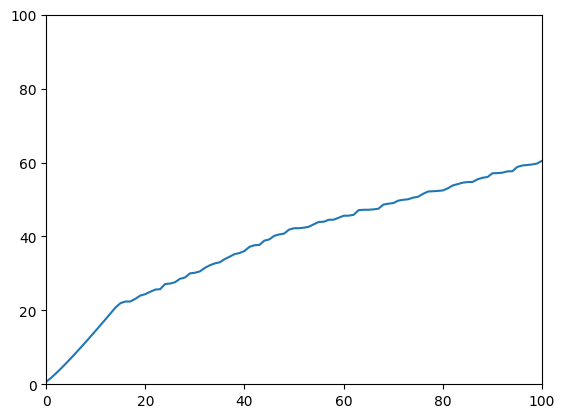

In [523]:
plt.plot(energies)
plt.xlim(0,100)
plt.ylim(0,100)

In [524]:
energies[:100]

array([ 0.64720612,  1.73403215,  2.96134991,  4.26938836,  5.63404309,
        7.04186149,  8.48425224,  9.95526924, 11.45056686, 12.96684072,
       14.50150086, 16.05246793, 17.61803966, 19.19679967, 20.7875532 ,
       21.95283765, 22.38928059, 22.40126449, 23.12287052, 24.00110265,
       24.39463021, 25.02762347, 25.62225461, 25.73316458, 27.12066055,
       27.25206589, 27.61700744, 28.54667659, 28.88994446, 30.0039344 ,
       30.17540962, 30.53536425, 31.48762666, 32.1878552 , 32.70719371,
       32.9938076 , 33.84699521, 34.51952326, 35.21614435, 35.51240336,
       36.06258571, 37.18373422, 37.62095643, 37.70498802, 38.8606741 ,
       39.19336866, 40.17576581, 40.54293619, 40.77827467, 41.85860131,
       42.22273454, 42.23025703, 42.37460215, 42.63064058, 43.30902514,
       43.92239655, 43.981501  , 44.5053106 , 44.53813054, 45.07100072,
       45.59808754, 45.61913169, 45.84441706, 47.11373126, 47.20942736,
       47.22362118, 47.32025435, 47.49827801, 48.61689242, 48.85

In [981]:
H =  DeltaE*two_state + omega*bosons_1 + 2*bosons_2 + 2*interaction_1 + U2*interaction_2

In [982]:

times = np.linspace(0.0, 10*2*np.pi, 500)

In [983]:
nnm_list[1200]

(400, 0, '-')

In [984]:
psi0 = basis(len(nnm_list), 1200)

In [985]:
result = sesolve(H, psi0, times, e_ops=[number_1, number_2, two_state+0.5])

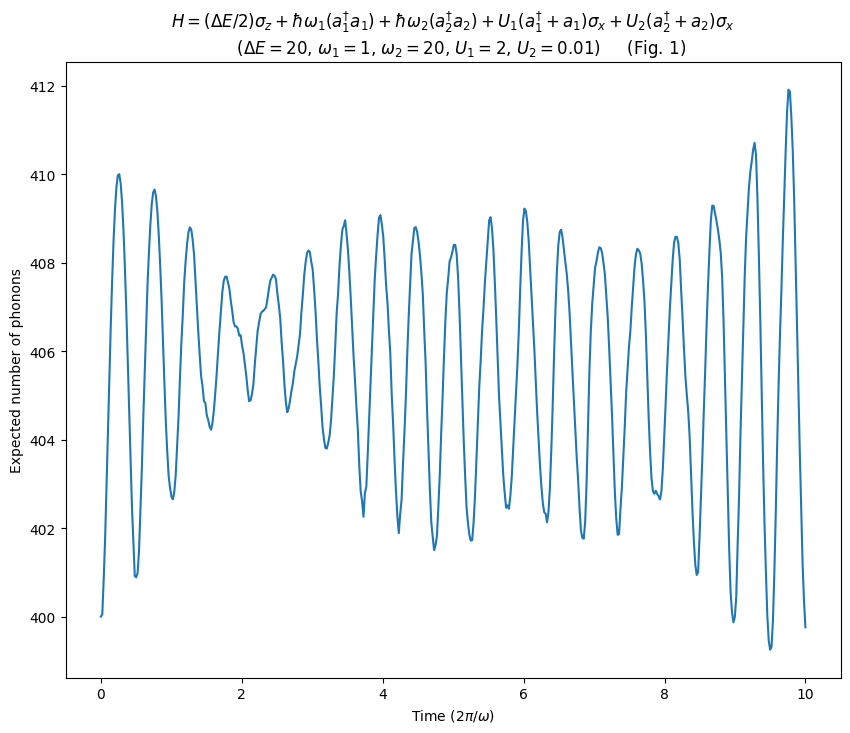

In [986]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[0], label="Expected number of phonons")

plt.ylabel("Expected number of phonons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_1={U1}$, $U_2={U2}$)     (Fig. 1)")
plt.show();

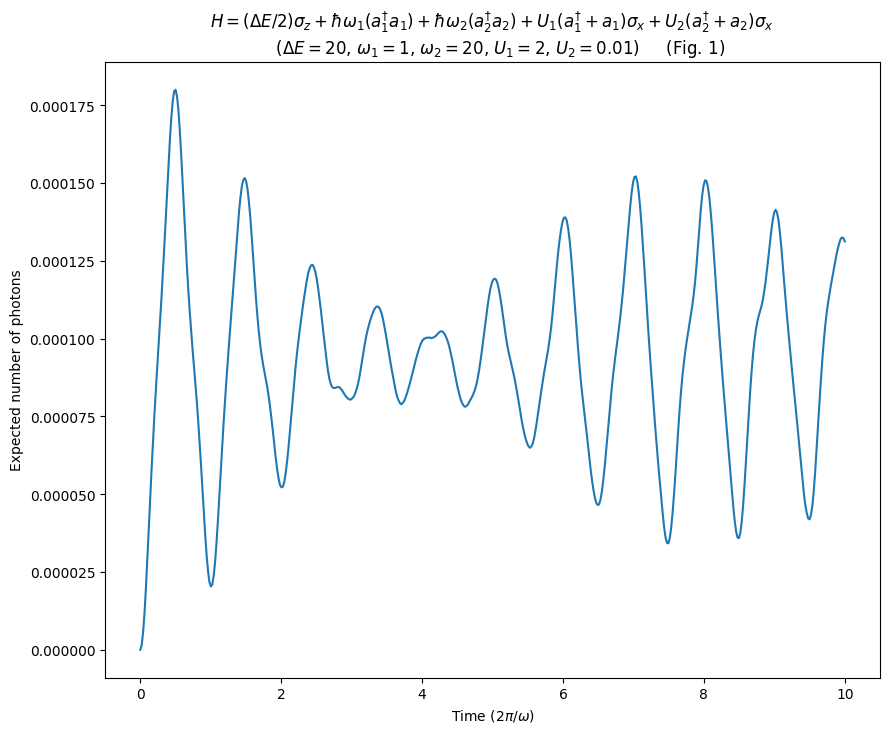

In [987]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[1], label="Expected number of photons")

plt.ylabel("Expected number of photons")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_1={U1}$, $U_2={U2}$)     (Fig. 1)")
plt.show();

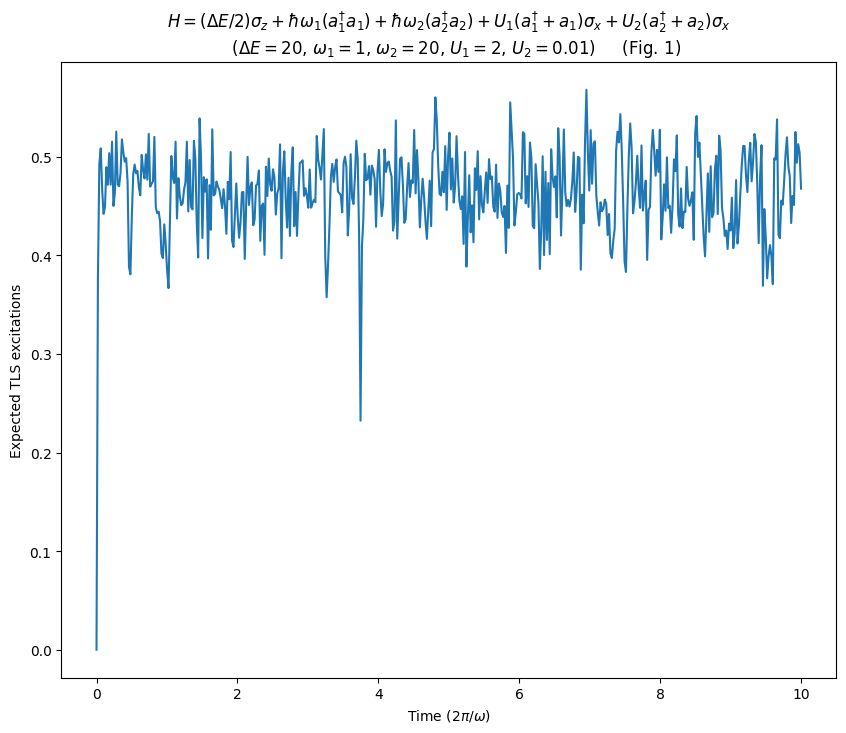

In [988]:
plt.figure(figsize=(10,8))
plt.plot(times/(2*np.pi), result.expect[2], label="Expected TLS excitations")

plt.ylabel("Expected TLS excitations")
plt.xlabel("Time ($2\pi/\omega$)")
# plt.legend(loc="right")
plt.title(f"{H_latex_2} \n   ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_1={U1}$, $U_2={U2}$)     (Fig. 1)")
plt.show();

In [989]:
n1s = projectors_all_n1(nnm_list)
n2s = projectors_all_n2(nnm_list)

In [990]:
result = sesolve(H, psi0, times, e_ops=n1s)

In [991]:
phonon_probs = np.array(result.expect)

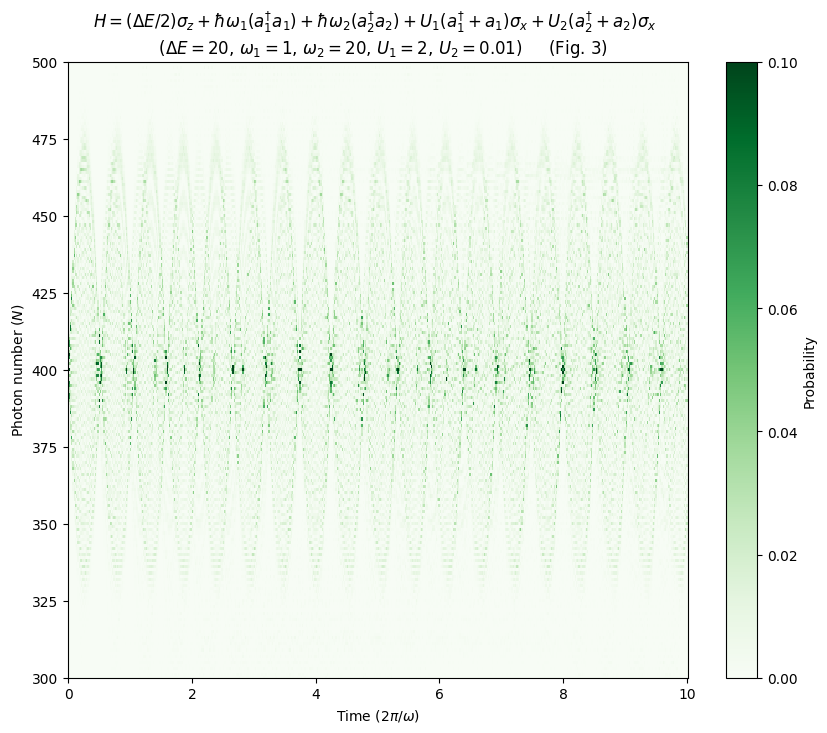

In [992]:
# Plot
plt.figure(figsize=(10,8))
plt.pcolormesh(times/(2*np.pi), np.arange(max_bosons+1), phonon_probs, shading='auto', cmap='Greens', vmax=0.1)
plt.colorbar(label="Probability")
plt.xlabel("Time ($2\pi/\omega$)")
plt.ylabel("Photon number ($N$)")
plt.ylim(bottom=300,top=500)
plt.title(f"{H_latex_2}  \n  ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_1={U1}$, $U_2={U2}$)     (Fig. 3)")

plt.show()

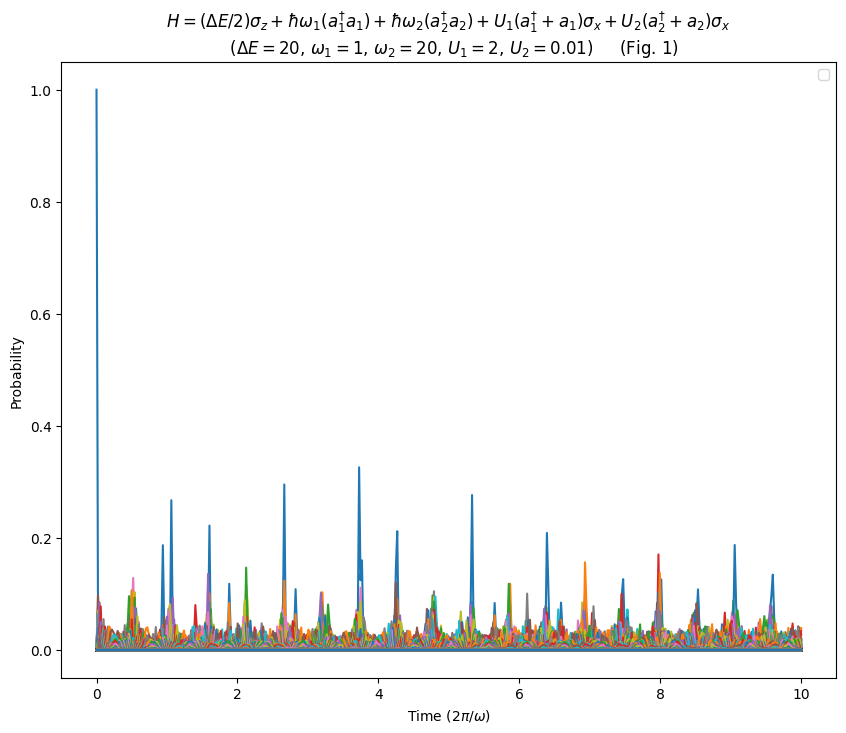

In [993]:
plot_sim(times/(2*np.pi),result.expect)
plt.title(f" {H_latex_2}  \n  ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_1={U1}$, $U_2={U2}$)     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");
plt.legend([])

In [994]:
result = sesolve(H, psi0, times, e_ops=n2s)

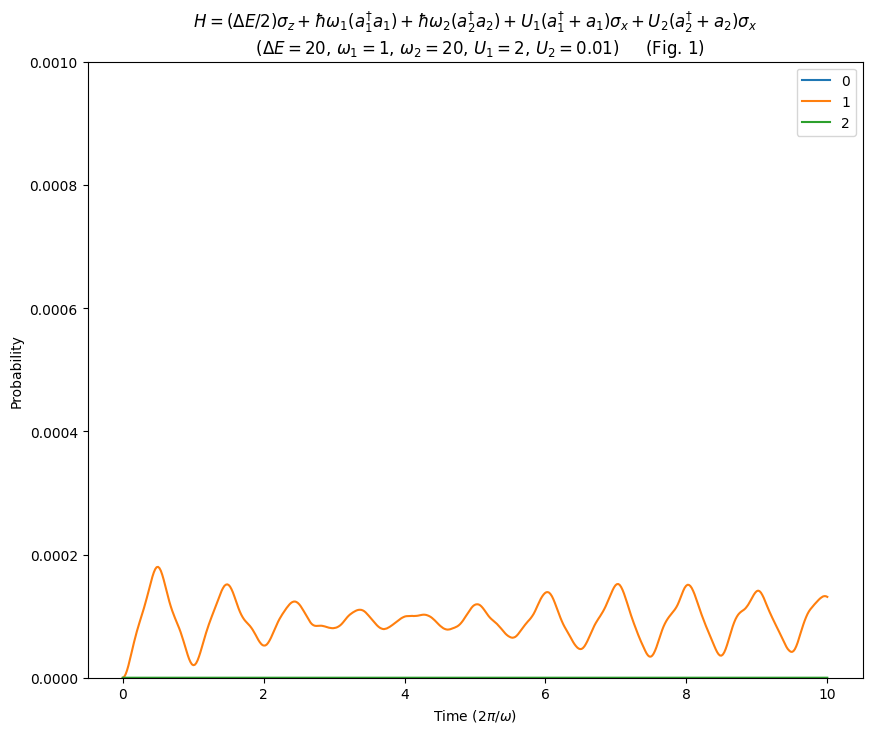

In [998]:
plot_sim(times/(2*np.pi),result.expect)
plt.title(f" {H_latex_2}  \n  ($\Delta E={DeltaE}$, $\omega_1={omega}$, $\omega_2={DeltaE}$, $U_1={U1}$, $U_2={U2}$)     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");
plt.ylim((0,1e-3))
plt.legend()

## 2 TLS

In [919]:
def make_operators_2(max_bosons, parity=0):
    a     = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    sx1   = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised 𝜎𝑥1 operator 
    sx2   = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised 𝜎𝑥2 operator 
    sz1   = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))       # tensorised 𝜎z1 operator 
    sz2   = tensor(qeye(max_bosons+1), qeye(2), sigmaz())       # tensorised 𝜎z2 operator 
    
    J     = jspin(2, basis="uncoupled")
    Jx    = tensor(qeye(max_bosons+1), J[0])                               # tensorised Jx operator
    Jz    = tensor(qeye(max_bosons+1), J[2])                               # tensorised Jx operator
    J2    = tensor(qeye(max_bosons+1), J[0]*J[0] + J[1]*J[1] + J[2]*J[2])  # tensorised J^2 operator
    
    two_state_1     =  1/2*sz1                                  # two state system energy operator   𝜎𝑧1/2
    two_state_2     =  1/2*sz2                                  # two state system energy operator   𝜎𝑧2/2
    bosons          = (a.dag()*a+0.5)                           # boson energy operator              𝑎†𝑎+1/2
    number          = a.dag()*a                                 # boson number operator              𝑎†𝑎
    interaction_1   = (a.dag() + a) * sx1                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥1  
    interaction_2   = (a.dag() + a) * sx2                       # interaction energy operator       (𝑎†+𝑎)𝜎𝑥2  
    
    P = sz1*sz2*(1j*np.pi*number).expm()                        # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
    
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        P               = P.extract_states(p)
        J2              = J2.extract_states(p)
        nmm_list        = [nmm_list[i] for i in p]

    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list

In [920]:
max_bosons =100

In [921]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nmm_list = make_operators_2(max_bosons=max_bosons, parity=-1)

In [931]:
# These are parameters from Casanova's paper "Deep Strong Coupling Regime of the Jaynes-Cummings Model"
DeltaE = 2.5
omega =1
U = 1

times = np.linspace(0.0, 100, 1000)

In [923]:
# These are realistic parameters for Pd nuclear transition and coupling with phonons 
# U/DeltaE = 0.01

DeltaE = 10**14
omega =1
U = 10**12

times = np.linspace(0.0, 50e-10, 3000)

In [932]:
H =  DeltaE*two_state_1 + DeltaE*two_state_2 + omega*bosons + U*interaction_1 + U*interaction_2


In [933]:
psi0 = basis(len(nmm_list), 0)

In [934]:
bra_labels, ket_labels = make_braket_labels(nmm_list)

In [935]:
projection_operators = [basis(len(nmm_list), i) * basis(len(nmm_list), i).dag() for i in range(len(nmm_list))]
result = sesolve(H, psi0, times, e_ops=projection_operators[:10])

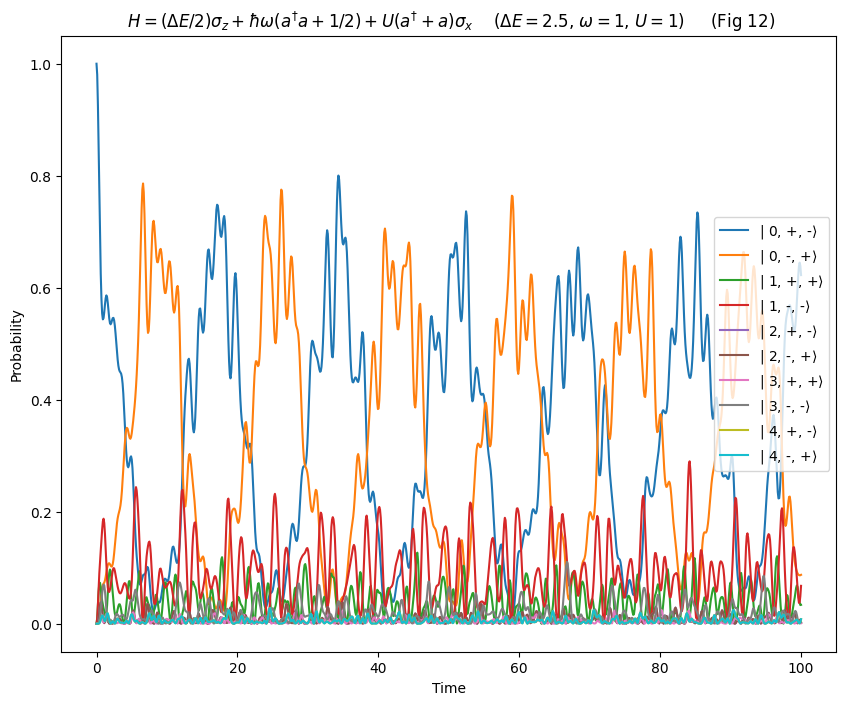

In [936]:
plot_sim(times,result.expect,labels=ket_labels)
plt.title(f" {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig 12)");


In [937]:
result = sesolve(H, psi0, times, e_ops=[H, number ])

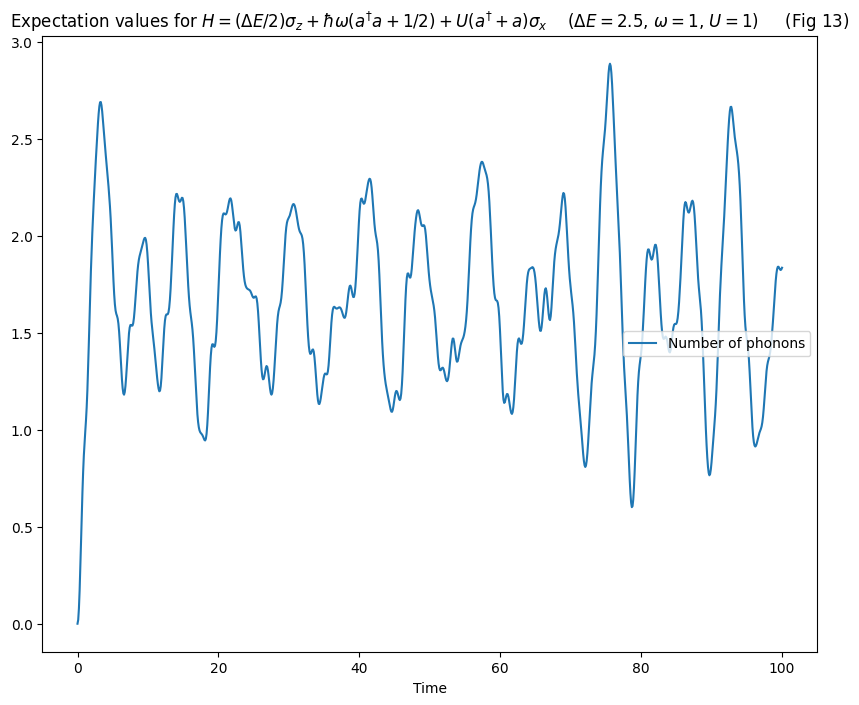

In [938]:
plt.figure(figsize=(10,8))
# plt.plot(times, result.expect[0], label="$H$ - Total Hamiltonian")
# plt.plot(times, result.expect[1], label="$(\Delta E/2) \sigma_z$ - TSS")
# plt.plot(times, result.expect[2], label="$\hbar\omega(a^{{\dagger}}a +1/2)$ - bosons")
# plt.plot(times, result.expect[3], label="$U( a^{{\dagger}} + a )\sigma_x$ - interaction")
plt.plot(times, result.expect[1], label="Number of phonons")

# plt.ylabel("Energy")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title(f"Expectation values for {H_latex}    ($\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$)     (Fig 13)")
plt.show();

## Coupling due to p in acp:

Coupling energy from momentum should go like:

$$\sim p c$$

From kinetic energy:

$$
\frac{p^2}{2m} = E \quad \Rightarrow \quad p = \sqrt{2mE}
$$

Let $E$ be oscillations:

$$
E = n \hbar \omega
$$

Thus,

$$
p = \sqrt{\frac{2mn\hbar\omega}{N}}
$$

(where energy spread over $N$ atoms)

$$
p = \sqrt{\frac{2m}{N}} \sqrt{\hbar \omega} \sqrt{n}
$$

(Note: going to drop the $\sqrt{n}$ soon because it should be picked up as part of a $(a^+ + a)$ operator.)

## Coupling due to a in acp:

From Peter's a matrix calculations we have 
$$ 2.6 \times 10^{-5} O$$

where $O \sim 0.01$


## Looking for a form of $U$:

I'm trying to map some of the acp physics onto a simple Hamiltonian

$$H =  \frac{\Delta E}{2} \sigma_z + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U\left( a^{\dagger} + a \right)\sigma_x$$


I think the mapping to $U$ looks like:

$$
U = c \sqrt{\frac{2m}{N}} \sqrt{\hbar \omega}  \times 2.6 \times 10^{-7}
$$

I'm most interested in $U$ normalised to $\hbar \omega$ so:

$$
\frac{U}{\hbar \omega} = \sqrt{\frac{2m c^2}{N \hbar \omega}} \times 2.6 \times 10^{-7}
$$


## Example for Pd (Palladium):

- $mc^2 \sim 10^9$ eV  
- $N \sim 10^{18}$  
- $\hbar \omega \sim 10^{-8}$ eV  

$$
\Rightarrow \frac{U}{\hbar \omega} = \sqrt{\frac{2 \times 10^{11}}{10^{18} \times 10^{-8}}} \times 2.6 \times 10^{-7}
$$

$$
= \sqrt{20} \times 2.6 \times 10^{-7} \sim 10^{-6}
$$

Thus,

$$
\frac{U}{\hbar \omega} \sim 10^{-6}
$$


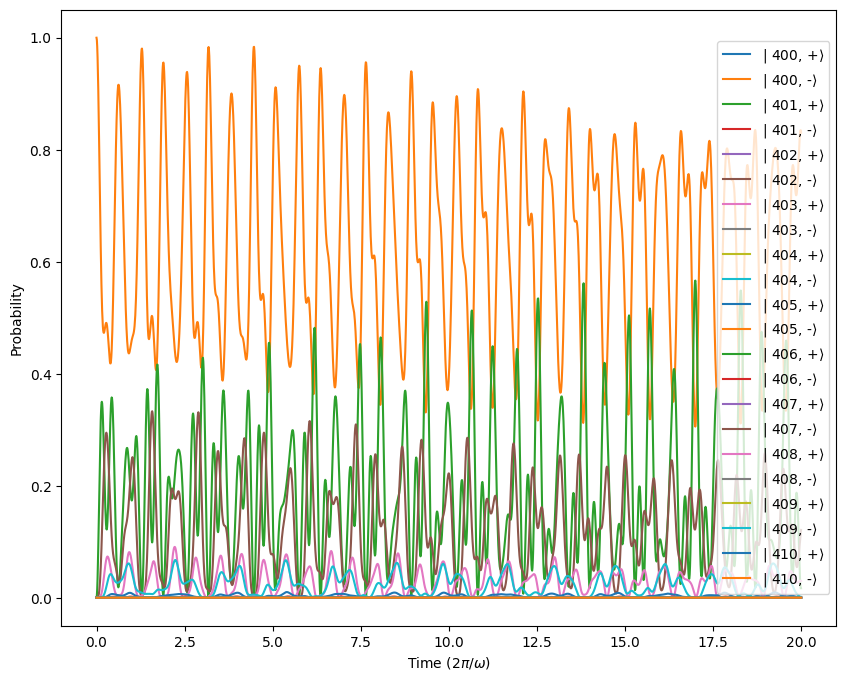

In [165]:


# Parameters
delta_E = 1.0  # TLS energy
omega = 1.0    # Oscillator frequency
g = 0.05       # Weak coupling strength
n_min = 400    # Minimum Fock state
n_max = 410    # Maximum Fock state
N = n_max - n_min + 1  # Oscillator Hilbert space dimension

possible_ns = range(n_min, n_max+1)
possible_ms = ["+","-"]
nm_list = [(n,m) for (n,m) in product(possible_ns, possible_ms)]

bra_labels, ket_labels = make_braket_labels(nm_list)

# TLS operators
sz = sigmaz()
sp = sigmap()
sm = sigmam()
# Oscillator operators
a = destroy(N,n_min)
ad = a.dag()
n_op = num(N,n_min)  # Number operator

# Hamiltonian
H_TLS = 0.5 * delta_E * tensor(sz, qeye(N))
H_osc = omega * tensor(qeye(2), n_op)
H_int = g * qt.tensor(sp + sm, a + ad)
H = H_TLS + H_osc + H_int

# Initial state: TLS in ground state, oscillator in |n=400>
# In truncated basis, |n=400> is at index 400 - n_min = 5
psi_osc = basis(N, n_min, n_min)
psi_TLS = basis(2, 1)  # Excited state |e>
psi0 = tensor(psi_TLS, psi_osc)

# Time evolution
tlist =np.linspace(0.0, 20*(2*np.pi/omega), 2000)
projection_operators = []

for osc_idx in range(n_min,n_max+1):  # 0: |n=400>, 1: |n=401>
    for tls_idx in range(2):  # 0: |e>, 1: |g>
        ket = tensor(basis(2, tls_idx), basis(N, osc_idx, n_min))
        projection_operators.append(ket.proj())

# result = mesolve(H, psi0, tlist, [], [tensor(sz, qeye(N)), tensor(qeye(2), n_op)])
result = sesolve(H, psi0, tlist, projection_operators)


plot_sim(tlist/(2*np.pi/omega), result.expect, labels=ket_labels)
# plt.title(f" {H_latex}   \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, $\Psi_0=|0,->$     (Fig. 1)");
plt.xlabel("Time ($2\pi/\omega$)");

In [134]:
1/((2*np.sqrt(n_max)*g))

500.0

In [111]:
nm_list

[(40, '+'),
 (40, '-'),
 (41, '+'),
 (41, '-'),
 (42, '+'),
 (42, '-'),
 (43, '+'),
 (43, '-'),
 (44, '+'),
 (44, '-'),
 (45, '+'),
 (45, '-')]